In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 7})
import seaborn as sns
import os
from copy import deepcopy
%matplotlib inline
#sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
#sns.set(font_scale=0.5)
#plt.rcParams['font.family'] = 'arial.ttf'
#sns.set(font='arial.ttf')

from sklearn.ensemble import RandomForestRegressor
import random
import math
import scipy.stats as stats
import scipy.signal
from scipy.stats import spearmanr, pearsonr
from sklearn import preprocessing
from tqdm import tqdm, trange
import pickle
from itertools import product
from collections import OrderedDict
import torch
import torch.nn.functional as F
seed = 1337
random.seed(seed)
np.random.seed(seed)
import matplotlib as mpl
import matplotlib
import torch.nn as nn

In [2]:
import argparse
from argparse import Namespace
from collections import Counter
parser = argparse.ArgumentParser()

parser.add_argument('--filename', type = str, default = './ESM2_finetuned/attentions_symm/Finetuned_4.1_train__CVESM2lr1e-5_ESM2SISS_FS4.1.ep93.1e-2.dr2_unmod_1_10folds_rl_LabelScalerFalse_LabelLog2False_AvgEmbFalse__attentions_symm.npz')
parser.add_argument('--ngrams', type = int, default = 8)
parser.add_argument('--ratio', action = 'store_true')
args = parser.parse_args([])
print(args)

global obj_col, seed
out_filename = f'SHAP_{args.ngrams}grams__' + '__'.join(args.filename.split('__')[1:3])
print(out_filename)

Namespace(filename='./ESM2_finetuned/attentions_symm/Finetuned_4.1_train__CVESM2lr1e-5_ESM2SISS_FS4.1.ep93.1e-2.dr2_unmod_1_10folds_rl_LabelScalerFalse_LabelLog2False_AvgEmbFalse__attentions_symm.npz', ngrams=8, ratio=False)
SHAP_8grams__CVESM2lr1e-5_ESM2SISS_FS4.1.ep93.1e-2.dr2_unmod_1_10folds_rl_LabelScalerFalse_LabelLog2False_AvgEmbFalse__attentions_symm.npz


In [3]:
def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

def performances(label, pred):
    
    r = r2(label, pred)
    pearson_r = pearsonr(label, pred)[0]
    sp_cor = spearmanr(label, pred)[0]
    print(f'r-squared = {r:.4f} | pearson r = {pearson_r:.4f} | spearman R = {sp_cor:.4f}')
            
    return [r, pearson_r, sp_cor]

In [4]:
def kmers_list(ngrams = 3):
    kmers = list('AGCT')
    for i in trange(1, ngrams):
        kmers = [''.join(c) for c in list(product(kmers, 'AGCT'))]
        print(f'{i+1}-mers: {len(kmers)}')
    return kmers

In [5]:
def generate_seqs_kmers_contacts_pd(data, kmers):
    seqs_kmers_contacts_pd = pd.DataFrame()
    i = 0
    for seq, attention_contacts in tqdm(zip(data['sequences'], data[obj_col])):
        seq = seq.replace('<pad>', '')
        attention_contacts = attention_contacts[:len(seq), :len(seq)]

        if args.ratio:
            attention_contrib_ratio = F.softmax(torch.Tensor(attention_contacts), dim = 0) # 列相加=1
            seq_contrib_ratio = np.array(attention_contrib_ratio.sum(axis = 1))

            temp_dict = create_ngram_list(seq, len(kmers[0]), seq_contrib_ratio, kmers)
        else:
            seq_contact_scores = attention_contacts.sum(axis = 1)

            temp_dict = create_ngram_list(seq, len(kmers[0]), seq_contact_scores, kmers)

        if i == 0: 
            seq_kmers_dict = deepcopy(temp_dict)
            i += 1
        else:
            seq_kmers_dict = dict(Counter(seq_kmers_dict) + Counter(temp_dict))
    
    return seq_kmers_dict

In [6]:
def create_ngram_list(seq, ngrams, contact_scores, kmers_list):
    kmers_dict = OrderedDict(zip(kmers_list, [0]*len(kmers_list)))
    
    if len(seq) >= ngrams:
        mer = zip(*[seq[i:] for i in range(ngrams)])
        con = zip(*[contact_scores[i:] for i in range(ngrams)])
        for m, c in zip(mer, con):
            tmp = ''.join(m)
            kmers_dict.setdefault(tmp, 0)
            kmers_dict[tmp] += sum(c)
            
    return kmers_dict

In [7]:
def generate_subset(a):
    subset = []
    for i in range(len(a)+1):
        for j in range(1, len(a)+1):
            if j > i: 
                temp = a[i:j]
                if temp != a:
                    subset.append(temp)
    return subset

In [8]:
obj_col = 'attentions_symm_ESM2'
pwd = '/home/ubuntu/esm2/Sample/Embedding_Contacts/ESM2_finetuned/attentions_symm/'
filename = 'Finetuned_VaryLengthHumanAll_pushLen50_sequence__CVESM2lr1e-5_ESM2SISS_FS4.1.ep93.1e-2.dr2_unmod_1_10folds_rl_LabelScalerFalse_LabelLog2False_AvgEmbFalse__attentions_symm.npz'
data = np.load(pwd + filename)
print(list(data.keys()))

attns = data[obj_col]
seqs = data['sequences']
labels = data['labels']
print(attns.shape, len(seqs))

index_nondup = np.array(pd.DataFrame(seqs).drop_duplicates().index)
seqs = seqs[index_nondup]
seqs = [s.replace('<pad>', 'N') for s in seqs]
labels = labels[index_nondup]
attns = attns[index_nondup]
print(attns.shape, len(seqs))

['sequences', 'labels', 'attentions_symm_ESM2']
(15555, 50, 50) 15555
(13216, 50, 50) 13216


In [9]:
def generate_kmer_motif_attention(attentions, k, sequences):
    
    attentions_1d = attentions.sum(axis = 1)
    attentions_1dconv = scipy.signal.fftconvolve(attentions_1d, np.ones((1, k)), mode = 'valid')
    attentions_1dconv_avg = attentions_1dconv / k
    attentions_1dconv_avg_flatten = attentions_1dconv_avg.flatten()
    print(attentions.shape, attentions_1d.shape, 
          attentions_1dconv_avg.shape, attentions_1dconv_avg_flatten.shape)
    ### generate motif
    motifs = []
    for s in tqdm(sequences):
        i = 0
        n = len(s) - k + 1
        while i < n:
            motifs.append(s[i: i+k])
            i += 1
    assert len(motifs) == attentions_1dconv_avg_flatten.shape[0]
    ### generate motif's attention and appeared number
    motif_attention = dict()
    motif_num = dict()
    for k, v in tqdm(zip(motifs, attentions_1dconv_avg_flatten)):
        try:
            motif_attention[k] += v
            motif_num[k] += 1
        except:
            motif_attention.setdefault(k, v)
            motif_num.setdefault(k, 1)

    motif_attention = sorted(motif_attention.items(), key=lambda x: x[1], reverse=True)
    motif_num = sorted(motif_num.items(), key=lambda x: x[1], reverse=True)
    return attentions_1dconv_avg_flatten, motifs, motif_attention, motif_num

In [10]:
for i, k in enumerate(range(3, 13)):
    _, motifs_kmer, motif_attention_kmer, motif_num_kmer = generate_kmer_motif_attention(attns, 
                                                                                         k, 
                                                                                         seqs)
    if i == 0:
        motifs, motif_attention, motif_num = list(set(motifs_kmer)), motif_attention_kmer, motif_num_kmer
    else:
        motifs.extend(list(set(motifs_kmer)))
        motif_attention.extend(motif_attention_kmer)
        motif_num.extend(motif_num_kmer)
    print(f'---{k} mer---', len(motifs_kmer), len(motif_attention_kmer), len(motifs))
motif_attention = sorted(motif_attention, key=lambda x: x[1], reverse=True)
motif_num = sorted(motif_num, key=lambda x: x[1], reverse=True)

(13216, 50, 50) (13216, 50) (13216, 48) (634368,)


100%|██████████| 13216/13216 [00:00<00:00, 91495.52it/s]
634368it [00:00, 1275100.71it/s]


---3 mer--- 634368 85 85
(13216, 50, 50) (13216, 50) (13216, 47) (621152,)


100%|██████████| 13216/13216 [00:00<00:00, 94474.10it/s]
621152it [00:00, 1231071.36it/s]


---4 mer--- 621152 341 426
(13216, 50, 50) (13216, 50) (13216, 46) (607936,)


100%|██████████| 13216/13216 [00:00<00:00, 96249.34it/s]
607936it [00:00, 1204648.95it/s]


---5 mer--- 607936 1362 1788
(13216, 50, 50) (13216, 50) (13216, 45) (594720,)


100%|██████████| 13216/13216 [00:00<00:00, 98712.88it/s]
594720it [00:00, 1147627.68it/s]


---6 mer--- 594720 5353 7141
(13216, 50, 50) (13216, 50) (13216, 44) (581504,)


100%|██████████| 13216/13216 [00:00<00:00, 103991.46it/s]
581504it [00:00, 1091763.74it/s]


---7 mer--- 581504 19922 27063
(13216, 50, 50) (13216, 50) (13216, 43) (568288,)


100%|██████████| 13216/13216 [00:00<00:00, 112542.07it/s]
568288it [00:00, 1029866.13it/s]


---8 mer--- 568288 66733 93796
(13216, 50, 50) (13216, 50) (13216, 42) (555072,)


100%|██████████| 13216/13216 [00:00<00:00, 122511.77it/s]
555072it [00:00, 950333.27it/s]


---9 mer--- 555072 165176 258972
(13216, 50, 50) (13216, 50) (13216, 41) (541856,)


100%|██████████| 13216/13216 [00:00<00:00, 120362.62it/s]
541856it [00:00, 889793.85it/s]


---10 mer--- 541856 275840 534812
(13216, 50, 50) (13216, 50) (13216, 40) (528640,)


100%|██████████| 13216/13216 [00:00<00:00, 120105.48it/s]
528640it [00:00, 879664.07it/s]


---11 mer--- 528640 345940 880752
(13216, 50, 50) (13216, 50) (13216, 39) (515424,)


100%|██████████| 13216/13216 [00:00<00:00, 117217.75it/s]
515424it [00:00, 827643.97it/s]


---12 mer--- 515424 374323 1255075


In [11]:
motif_attention[-100:]

[('NNNCAAGAG', -1.3381242752075194e-05),
 ('CAGTCAGGACA', -1.3404949144883588e-05),
 ('NNNGTTGGT', -1.3420979181925455e-05),
 ('AGTCAGGACACA', -1.3429050644238792e-05),
 ('NNNGTTGGTCC', -1.3505531982942063e-05),
 ('CAGTCAGGACAC', -1.3516594966252644e-05),
 ('AGTCAGGACAC', -1.3541768897663465e-05),
 ('TCCGGTTCTGAC', -1.3543137659629187e-05),
 ('CCGGTTCTGACG', -1.3571387777725853e-05),
 ('CGGTTCTGACGG', -1.3626025368769964e-05),
 ('CGGTTCTGACG', -1.3626265254887667e-05),
 ('NNNGGTCA', -1.3665761798620226e-05),
 ('TTCCGGTTCTG', -1.370110972361131e-05),
 ('CCGGTTCTGAC', -1.3751570474017752e-05),
 ('GGGCGGGGCCA', -1.377544619820335e-05),
 ('TTCCGGTTCTGA', -1.3781866679588953e-05),
 ('NNTCTTG', -1.379474997520447e-05),
 ('NNNGGGCC', -1.3805925846099855e-05),
 ('NNAGGAT', -1.3825616666248866e-05),
 ('CGGTTCTGAC', -1.3829953968524932e-05),
 ('GGGGCGGGGCCA', -1.3870497544606526e-05),
 ('NNNGTTGGTCCC', -1.3932275275389355e-05),
 ('NNCTCTTA', -1.3964716345071793e-05),
 ('NNCTCTTAA', -1.3967769013

In [12]:
kozak = 'GCCACCATGG'

In [13]:
motif_num

[('NNN', 62044),
 ('NNNN', 56991),
 ('NNNNN', 52146),
 ('NNNNNN', 47503),
 ('NNNNNNN', 43074),
 ('NNNNNNNN', 38852),
 ('NNNNNNNNN', 34821),
 ('NNNNNNNNNN', 31019),
 ('NNNNNNNNNNN', 27431),
 ('NNNNNNNNNNNN', 24071),
 ('GCC', 18233),
 ('GGC', 17980),
 ('CTG', 16647),
 ('CAG', 16371),
 ('GAG', 15594),
 ('GGG', 15055),
 ('CCC', 14609),
 ('CGG', 14564),
 ('GCG', 14502),
 ('AGC', 14154),
 ('GGA', 13763),
 ('AGG', 13465),
 ('CCG', 13396),
 ('CGC', 13257),
 ('GCT', 12984),
 ('CTC', 12853),
 ('CCT', 12091),
 ('TCC', 11972),
 ('TGG', 11254),
 ('AGA', 11247),
 ('CCA', 11011),
 ('GCA', 10880),
 ('TGC', 10729),
 ('AAG', 9826),
 ('GAA', 9752),
 ('GTG', 9683),
 ('TCT', 9540),
 ('GAC', 8637),
 ('CAC', 8547),
 ('ACC', 8394),
 ('TTC', 8347),
 ('CTT', 8086),
 ('GGT', 7931),
 ('TGA', 7845),
 ('GTC', 7712),
 ('TTT', 7679),
 ('AAA', 7285),
 ('TTG', 7009),
 ('TCA', 6930),
 ('TGT', 6722),
 ('ACA', 6511),
 ('AGT', 6490),
 ('GCGG', 6308),
 ('ACT', 6268),
 ('CAA', 6232),
 ('GGAG', 5932),
 ('GTT', 5833),
 ('GCTG'

In [14]:
motif_num_dict = {item[0]: item[1] for item in motif_num}
motif_num_dict

{'NNN': 62044,
 'NNNN': 56991,
 'NNNNN': 52146,
 'NNNNNN': 47503,
 'NNNNNNN': 43074,
 'NNNNNNNN': 38852,
 'NNNNNNNNN': 34821,
 'NNNNNNNNNN': 31019,
 'NNNNNNNNNNN': 27431,
 'NNNNNNNNNNNN': 24071,
 'GCC': 18233,
 'GGC': 17980,
 'CTG': 16647,
 'CAG': 16371,
 'GAG': 15594,
 'GGG': 15055,
 'CCC': 14609,
 'CGG': 14564,
 'GCG': 14502,
 'AGC': 14154,
 'GGA': 13763,
 'AGG': 13465,
 'CCG': 13396,
 'CGC': 13257,
 'GCT': 12984,
 'CTC': 12853,
 'CCT': 12091,
 'TCC': 11972,
 'TGG': 11254,
 'AGA': 11247,
 'CCA': 11011,
 'GCA': 10880,
 'TGC': 10729,
 'AAG': 9826,
 'GAA': 9752,
 'GTG': 9683,
 'TCT': 9540,
 'GAC': 8637,
 'CAC': 8547,
 'ACC': 8394,
 'TTC': 8347,
 'CTT': 8086,
 'GGT': 7931,
 'TGA': 7845,
 'GTC': 7712,
 'TTT': 7679,
 'AAA': 7285,
 'TTG': 7009,
 'TCA': 6930,
 'TGT': 6722,
 'ACA': 6511,
 'AGT': 6490,
 'GCGG': 6308,
 'ACT': 6268,
 'CAA': 6232,
 'GGAG': 5932,
 'GTT': 5833,
 'GCTG': 5822,
 'CGGC': 5706,
 'CAGC': 5630,
 'CTGC': 5582,
 'AAC': 5505,
 'GCAG': 5480,
 'GGCC': 5411,
 'GGCG': 5319,
 'G

In [15]:
motif_length = dict()
motif_length[-1] = []
for kv in tqdm(motif_attention):
    motif_n = len(kv[0])
    motif_length.setdefault(motif_n, [])
    motif_info = list(kv)
    motif_info.append(motif_num_dict[motif_info[0]])
    motif_length[motif_n].append(motif_info)
    motif_length[-1].append(motif_info)

100%|██████████| 1255075/1255075 [00:05<00:00, 241125.96it/s]


In [77]:
for motif_n, motifs in tqdm(motif_length.items()):
    print(motif_n, len(motifs))
    if motif_n == -1:
        motif_n = '3-12'
    with open(f'VaryLength_Human_pushLen50_{motif_n}mer_motif_attention.txt', 'w') as f:
        f.write('Motif, Attention Score, Count in the Human Dataset\n')
        for item in motifs:
            f.write(f'{item}\n')

  0%|          | 0/11 [00:00<?, ?it/s]

-1 1255075


 64%|██████▎   | 7/11 [00:02<00:01,  3.46it/s]

3 85
4 341
5 1362
6 5353
7 19922
8 66733
9 165176
10 275840


 82%|████████▏ | 9/11 [00:03<00:00,  3.05it/s]

11 345940
12 374323


100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


### heatmap 

In [17]:
def annotate_heatmap(im, data=None, values = None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(values.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center",
#               font = font1,
             )
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
#             kw.update(color=textcolors[int(im.norm(values[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [18]:
def heatmap(data, ax=None, cbar_kw={}, cbarlabel = "", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, aspect = 'auto', **kwargs)
    # Create colorbar
    cbar = ax.figure.colorbar(im, cax = None, ax = ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation = -90, va = "bottom")
    return im, cbar

In [57]:
def reshape_list_tangular(data_list, dim = 8):
    # 创建一个8x8的列表
    result_list = [[None] * dim for _ in range(dim)]

    # 填充元素到8x8列表
    for i in range(dim):
        for j in range(dim):
            index = i * dim + j  # 根据索引计算要填充的元素位置
            if index < len(data_list):
                result_list[i][j] = data_list[index]

    return np.array(result_list)


In [26]:
top_n = 10
heatmap_motifs = []
heatmap_index = []
for motif_n, motifs in tqdm(motif_length.items()):
    motifs = [[item[0], item[1]] for item in motifs]
    heatmap_motifs.append(motifs[:top_n**2])
    heatmap_index.append(motif_n)
heatmap_motifs

100%|██████████| 11/11 [00:04<00:00,  2.56it/s]


[[['GCC', 0.15211886105438102],
  ['CTG', 0.14557562520106673],
  ['GGC', 0.14213968689243045],
  ['CAG', 0.1408971948549163],
  ['GAG', 0.13157607863346718],
  ['CCC', 0.12785012306024623],
  ['GGG', 0.12056961096823209],
  ['AGC', 0.11881985049694695],
  ['GGA', 0.11600753354529555],
  ['AGG', 0.11565286200493499],
  ['CTC', 0.11286709023018651],
  ['GCT', 0.11189933897306516],
  ['CGG', 0.11043571401387411],
  ['GCG', 0.11024372621128903],
  ['CCT', 0.10894590647270327],
  ['CCG', 0.10824005926648794],
  ['TCC', 0.10705830715596625],
  ['CGC', 0.10669263452291529],
  ['AGA', 0.09984349117924768],
  ['CCA', 0.09836190193891531],
  ['TGG', 0.09669803672780612],
  ['TGC', 0.09252857075383254],
  ['GCA', 0.09019657627989815],
  ['TCT', 0.08653545690079517],
  ['AAG', 0.08533531582603893],
  ['GAA', 0.0850360083083308],
  ['GTG', 0.0820067354167499],
  ['TTC', 0.07563186467935631],
  ['CAC', 0.07387977714339876],
  ['GAC', 0.07356730879594889],
  ['CTT', 0.07326985212663828],
  ['TTT', 0

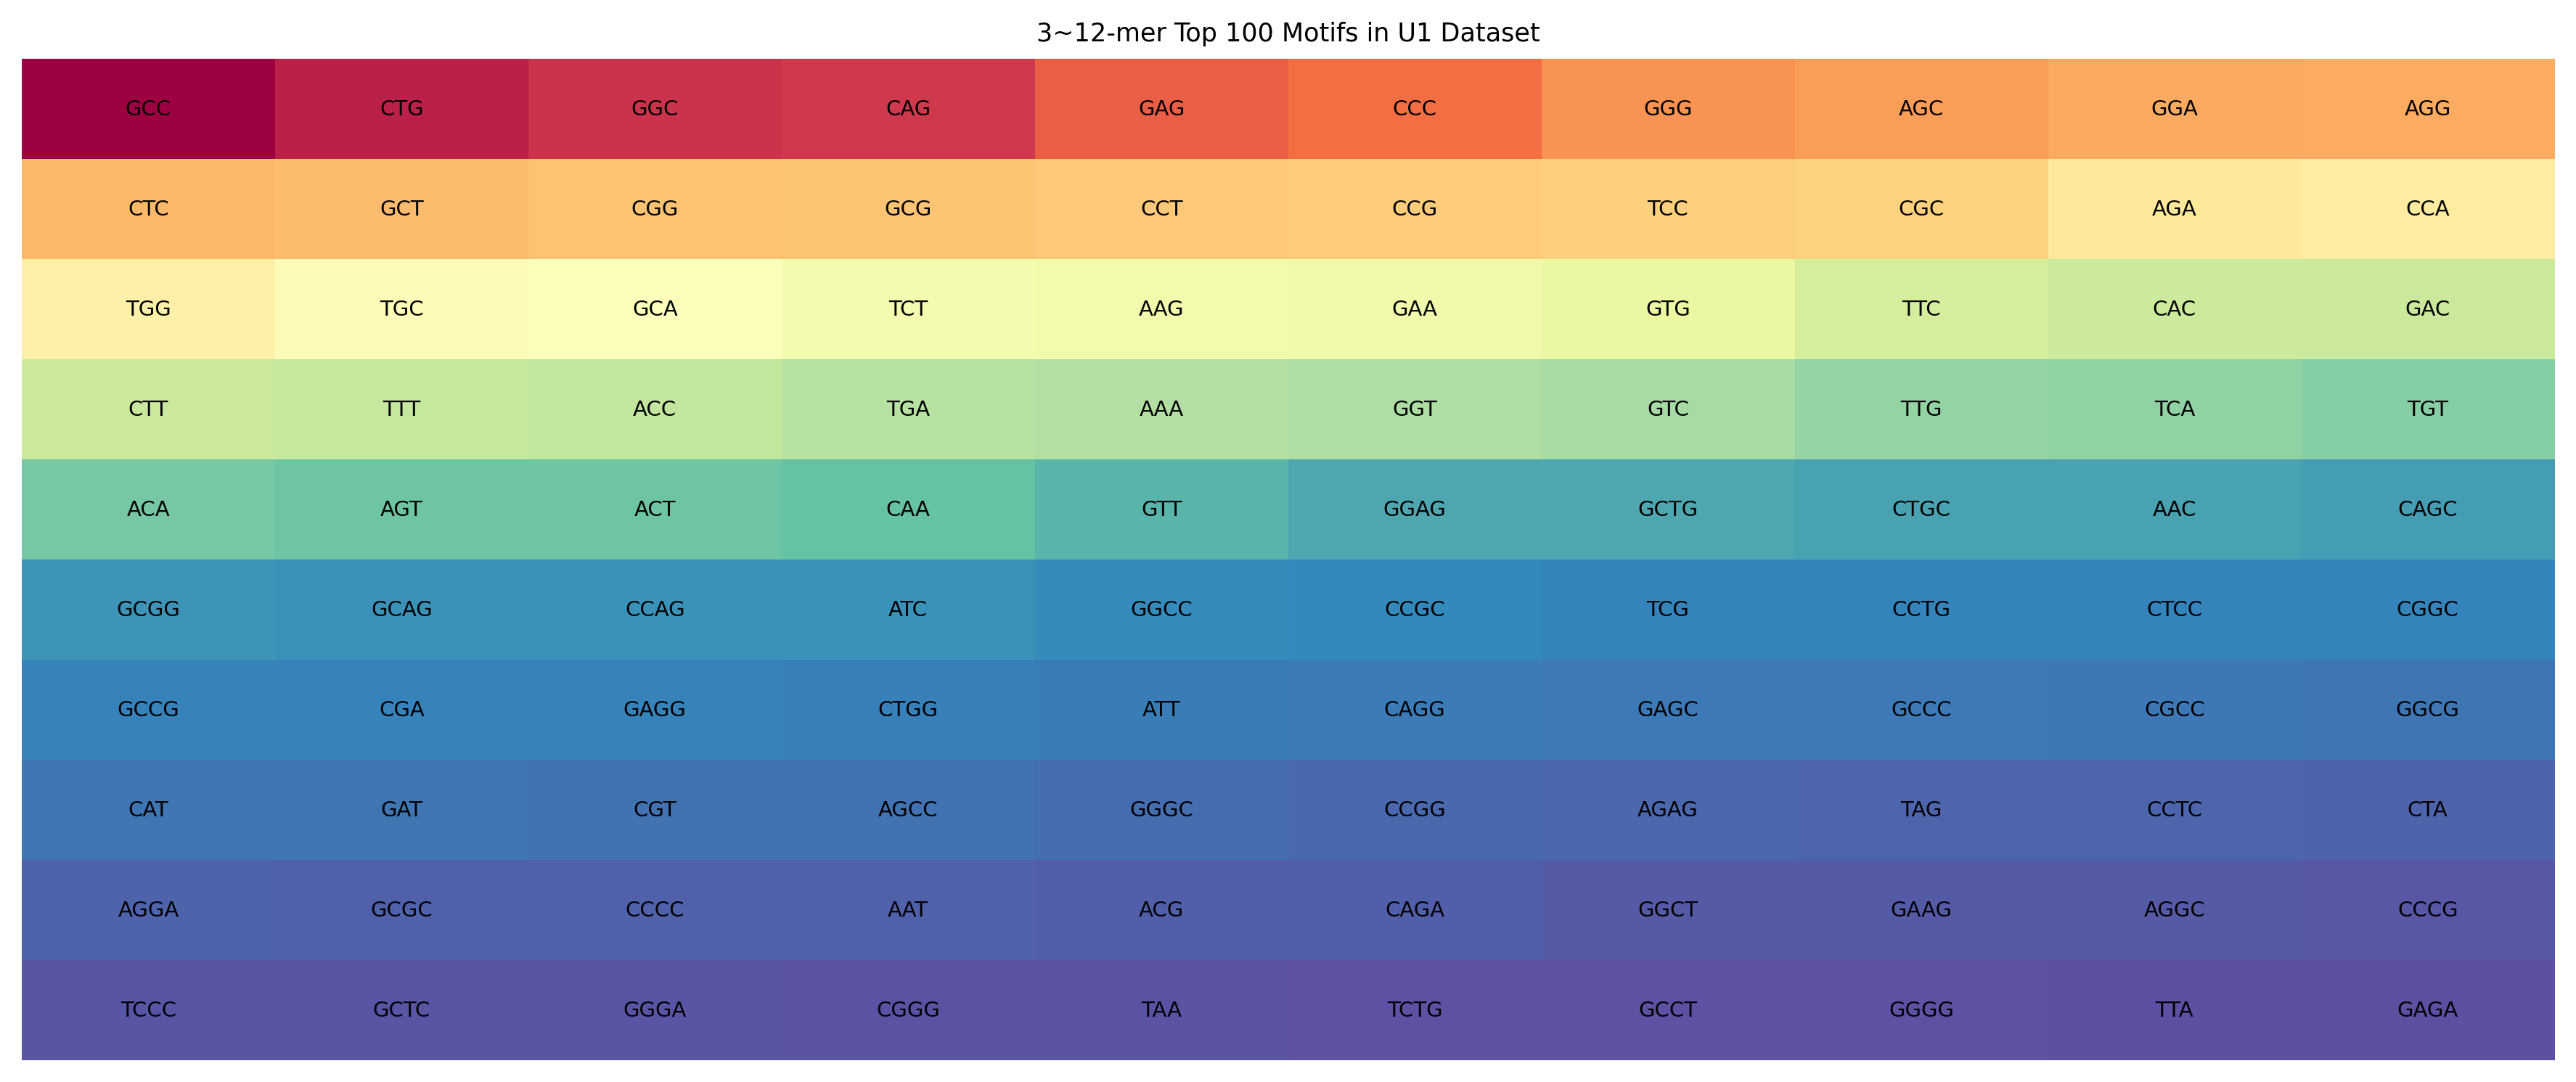

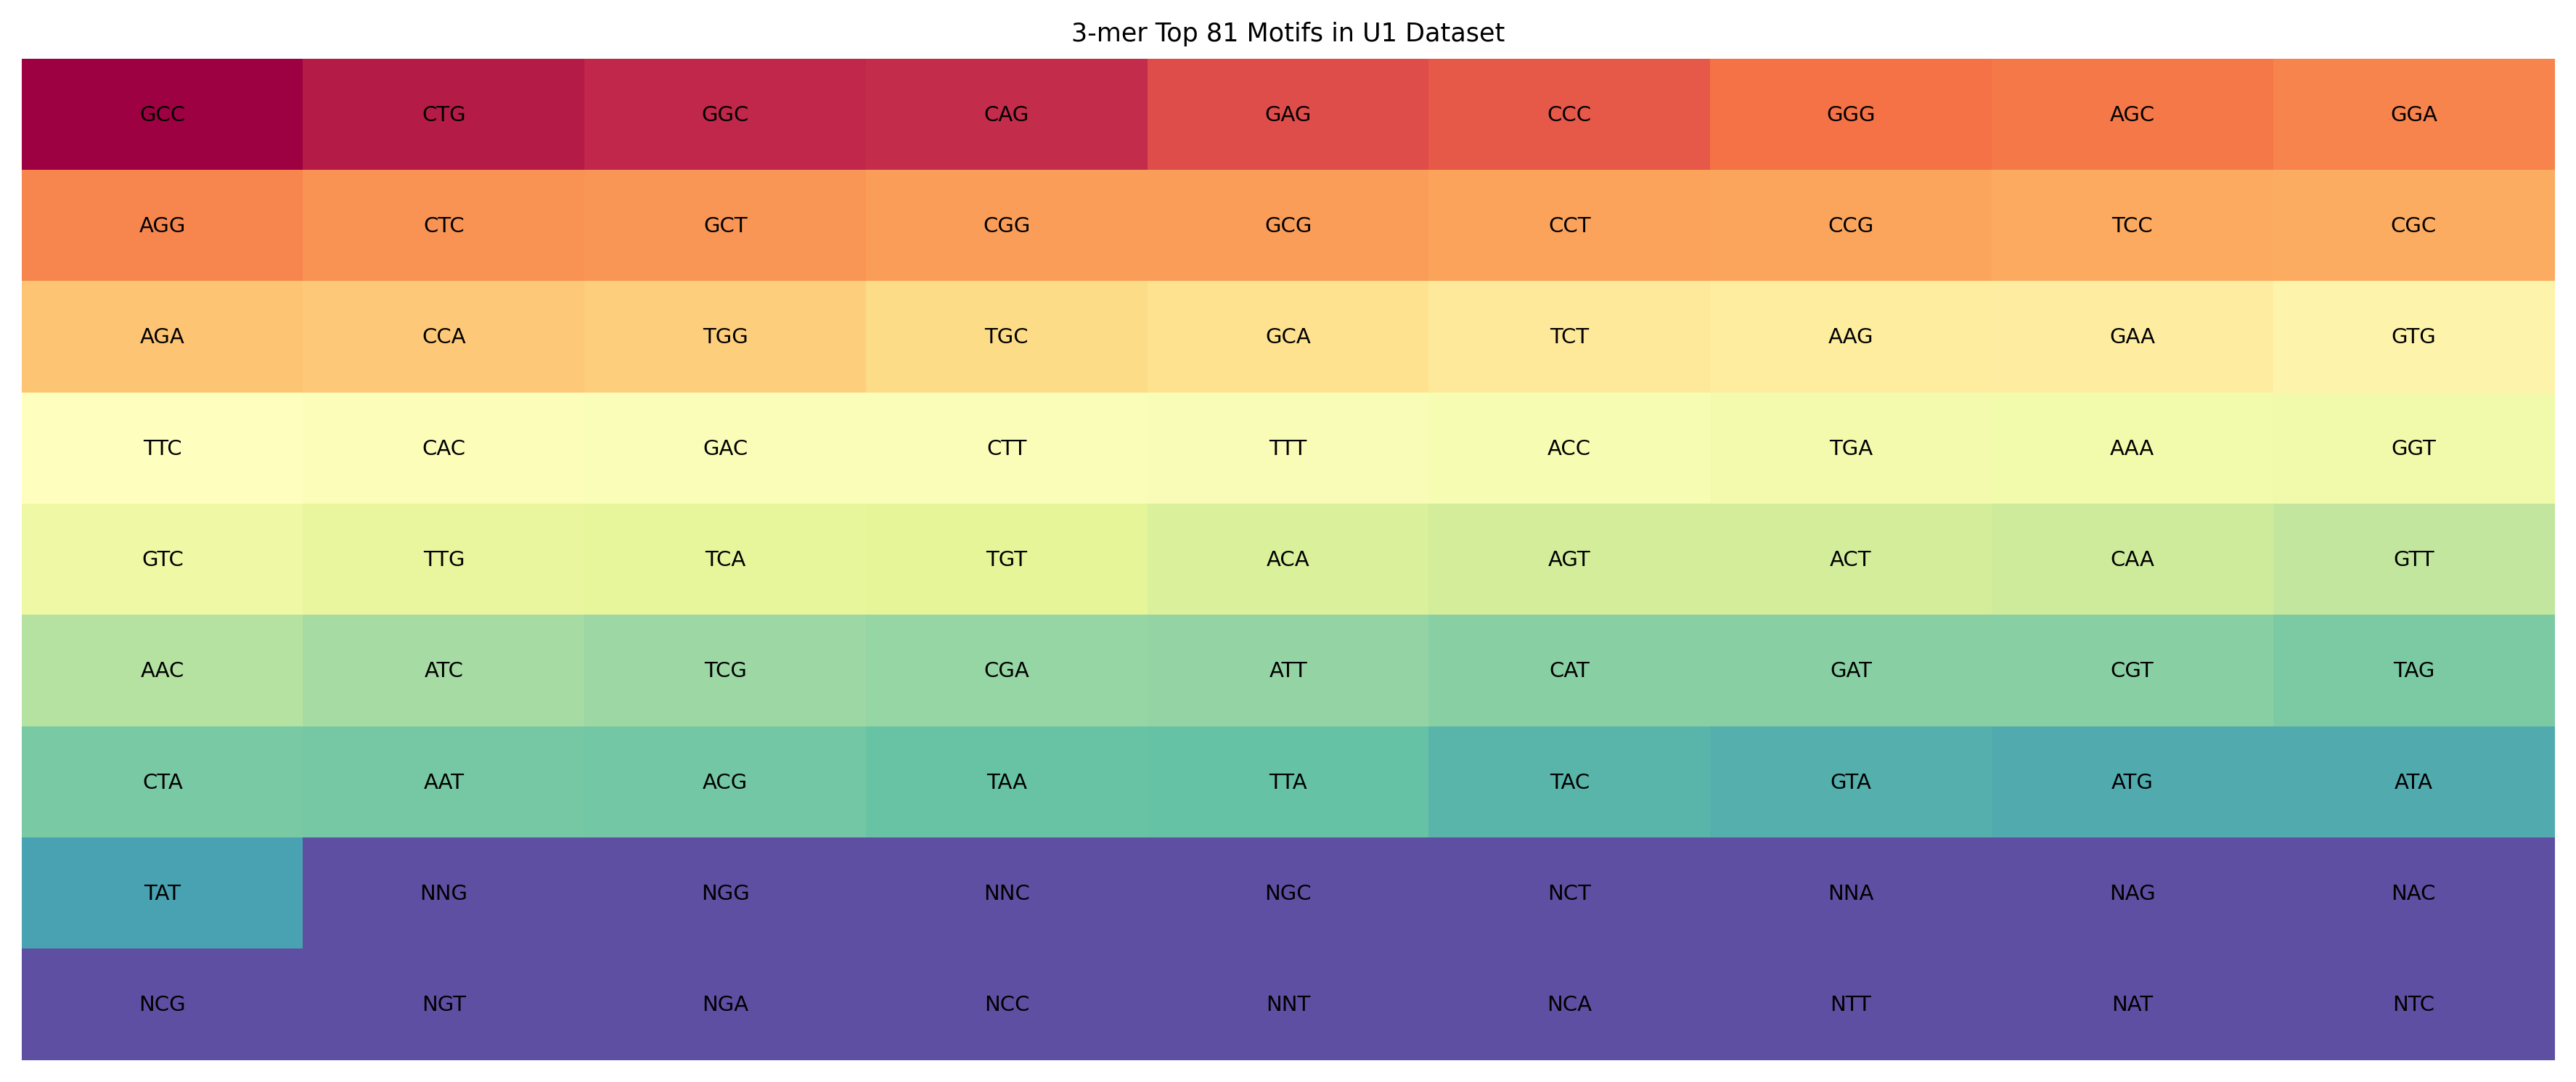

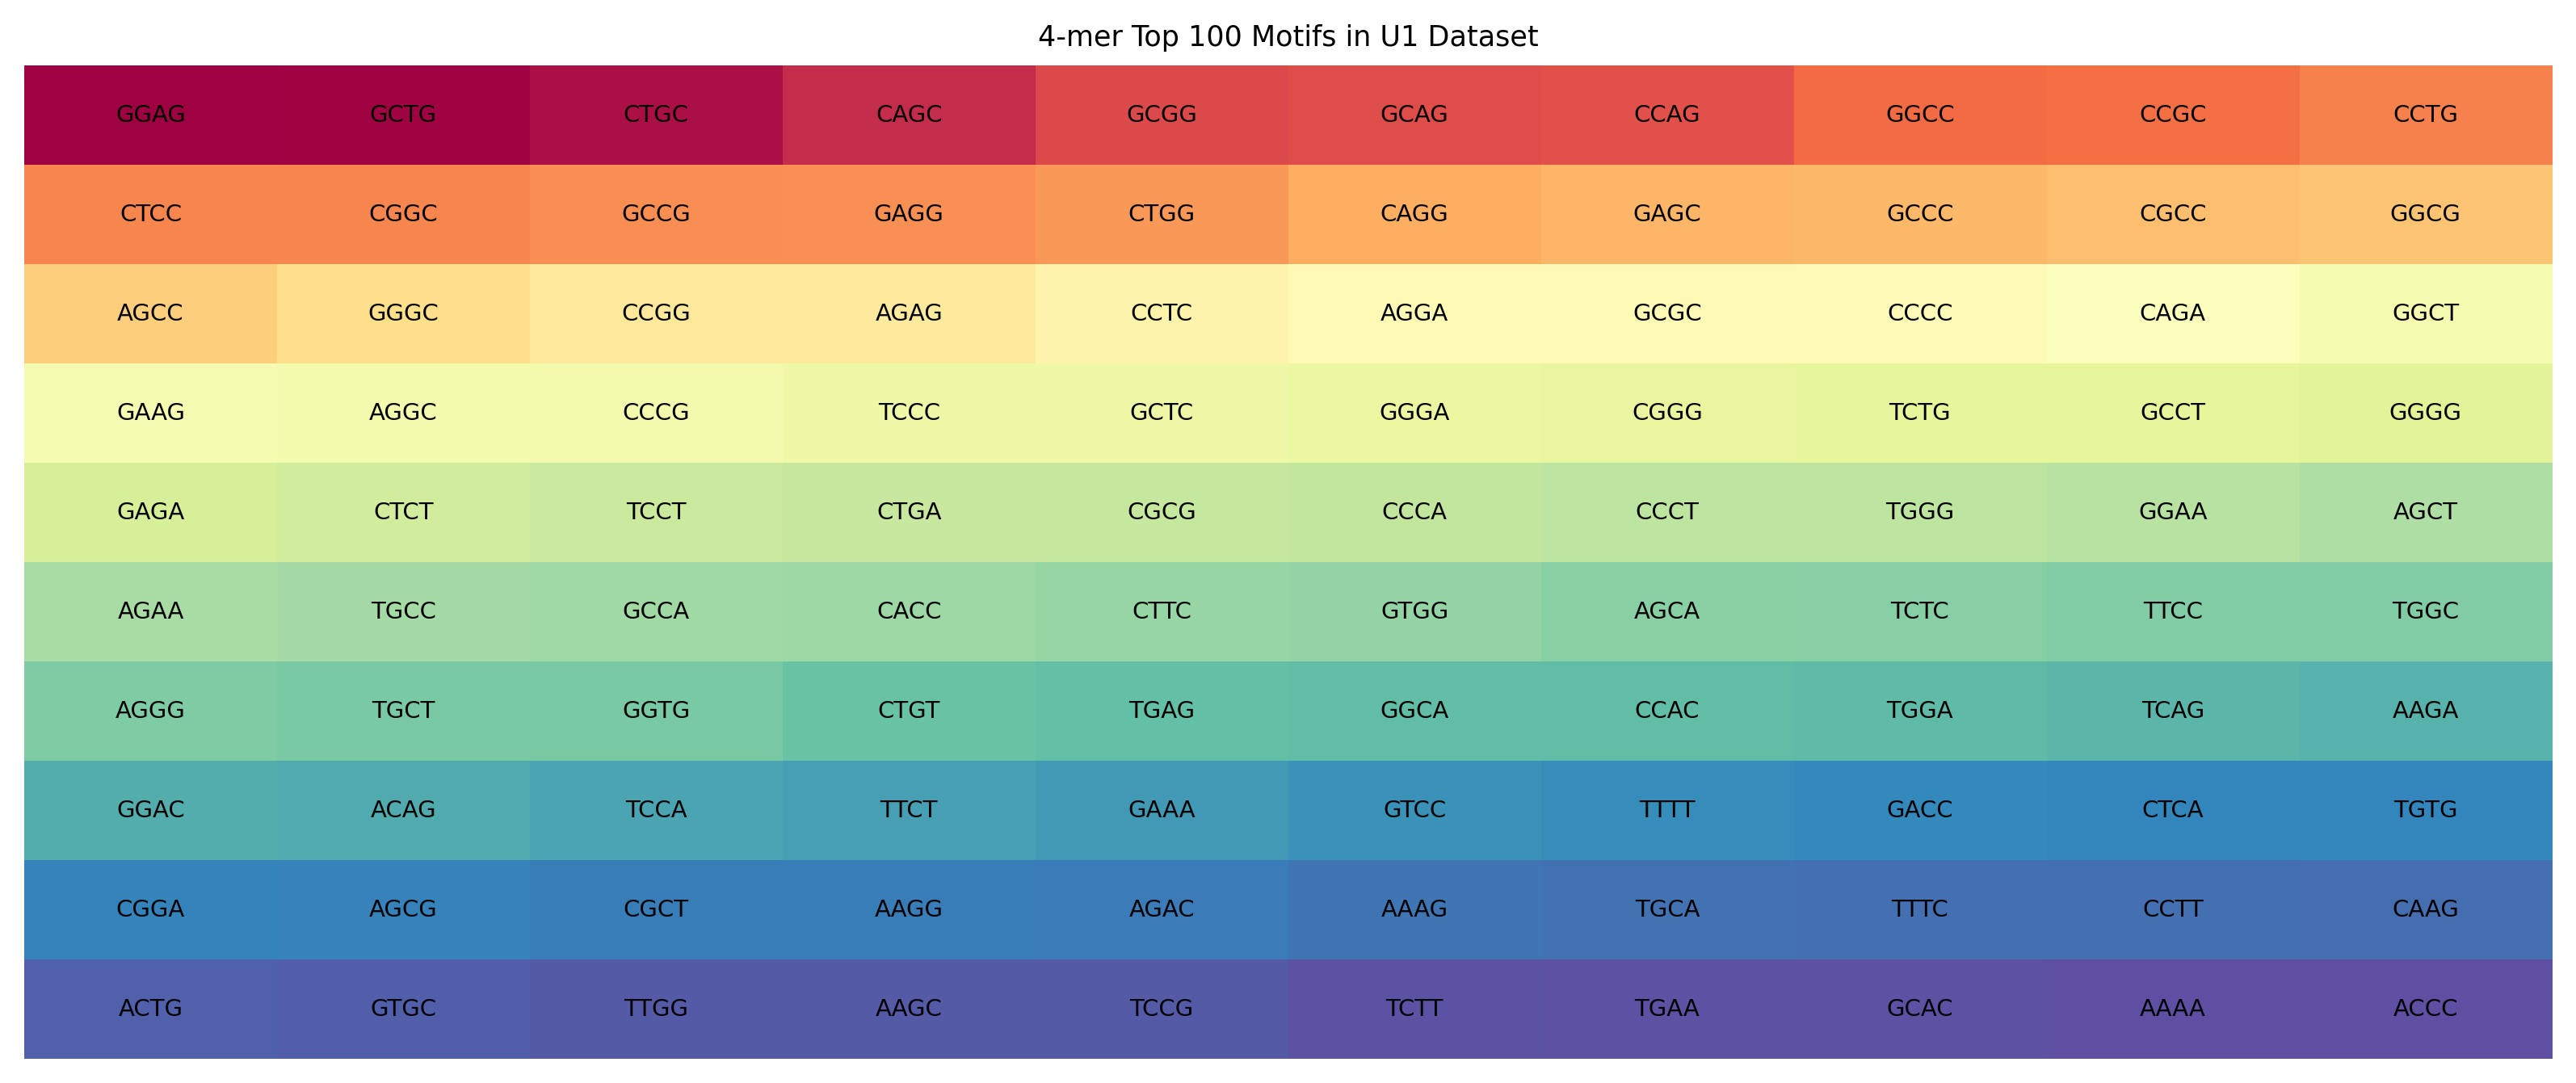

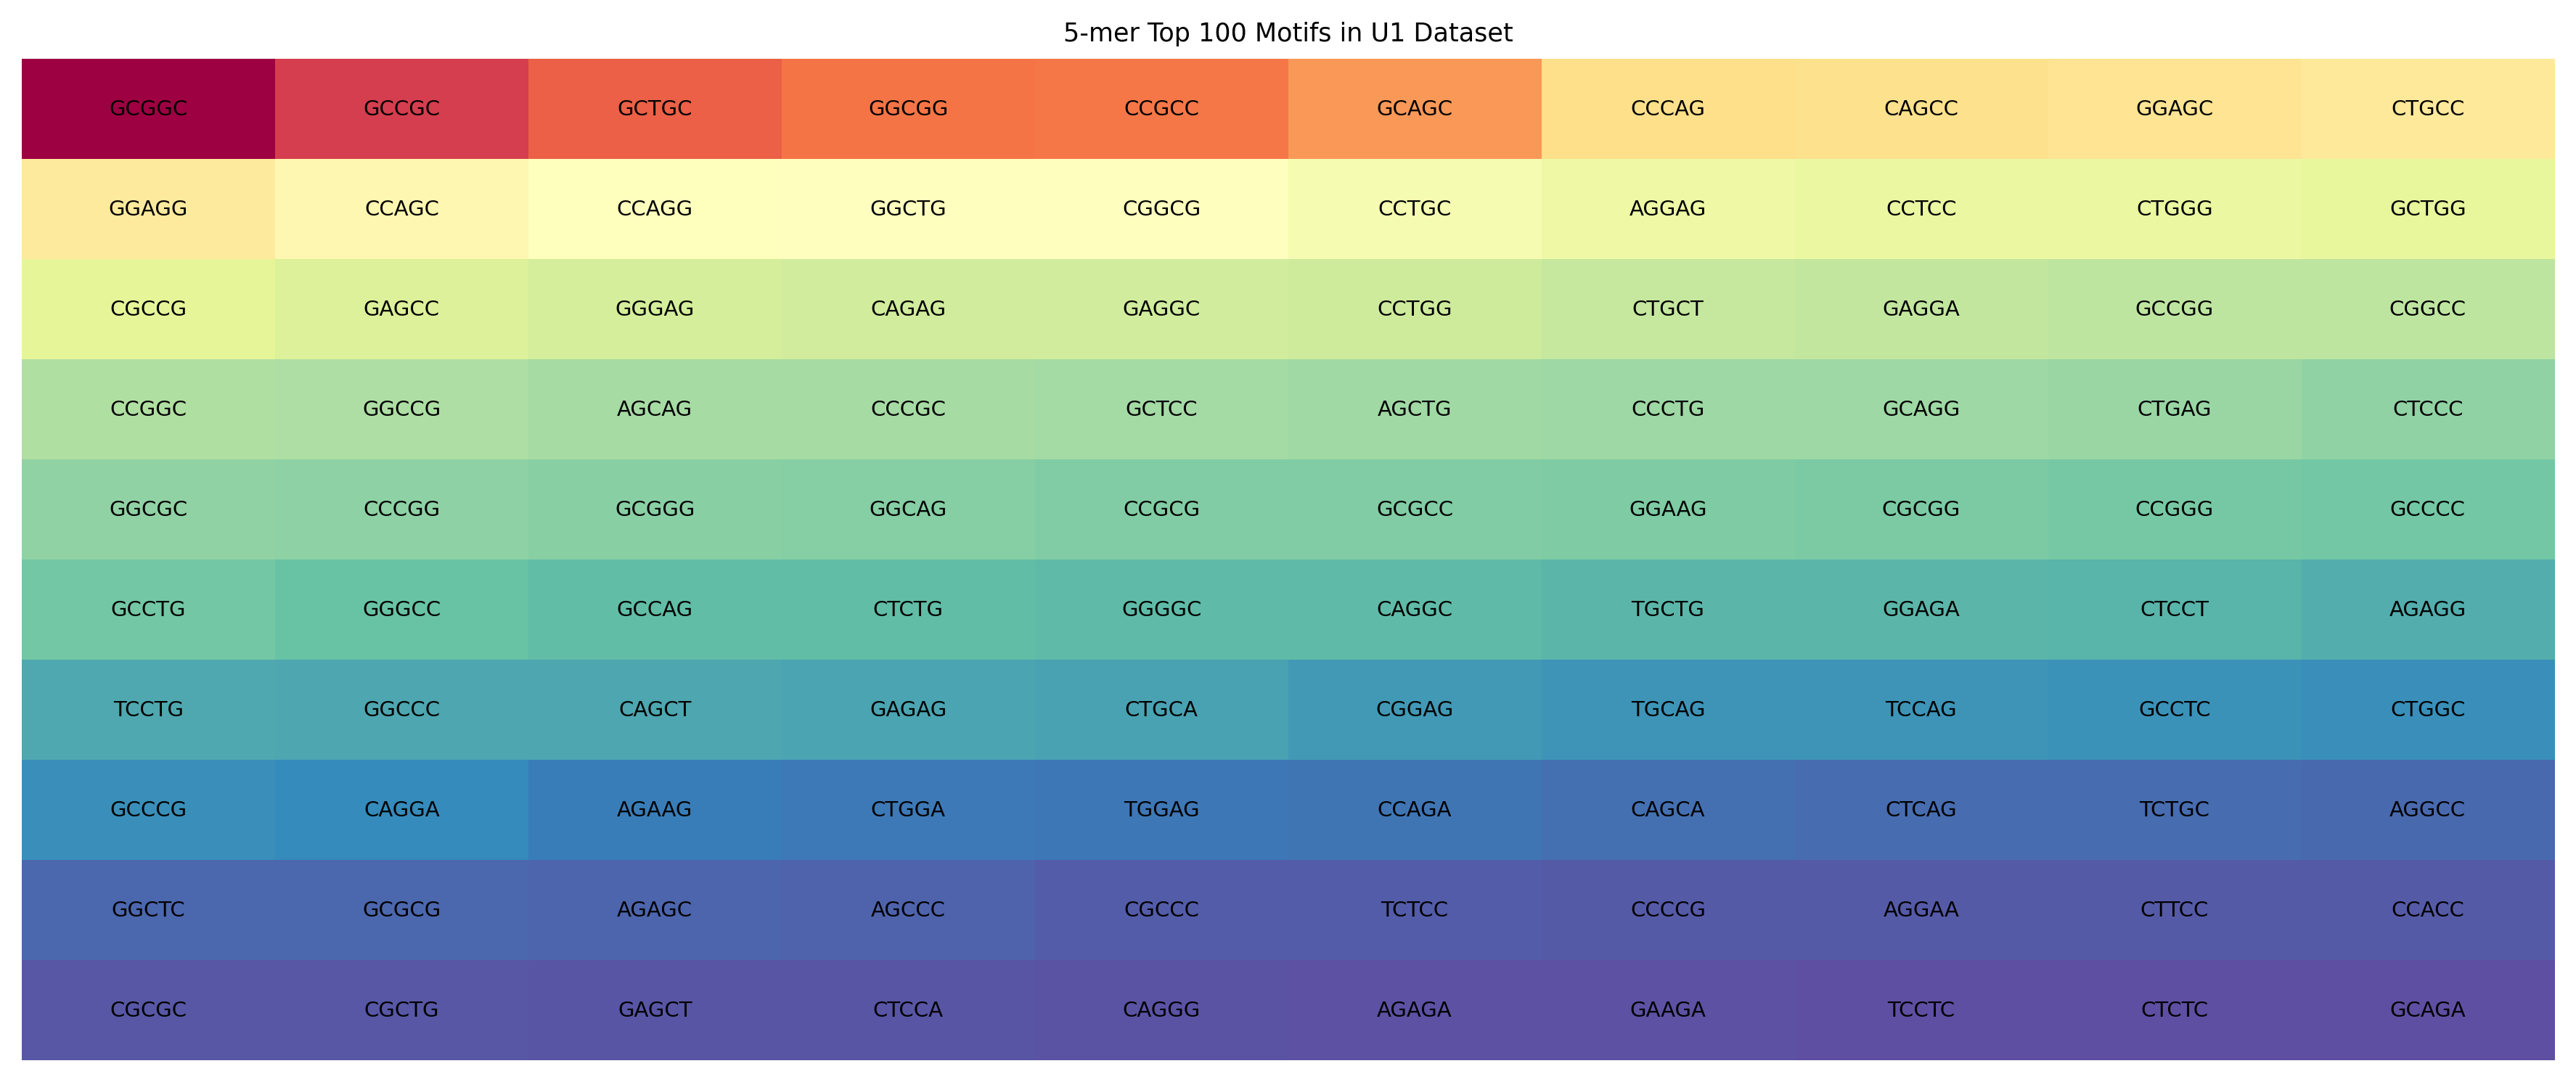

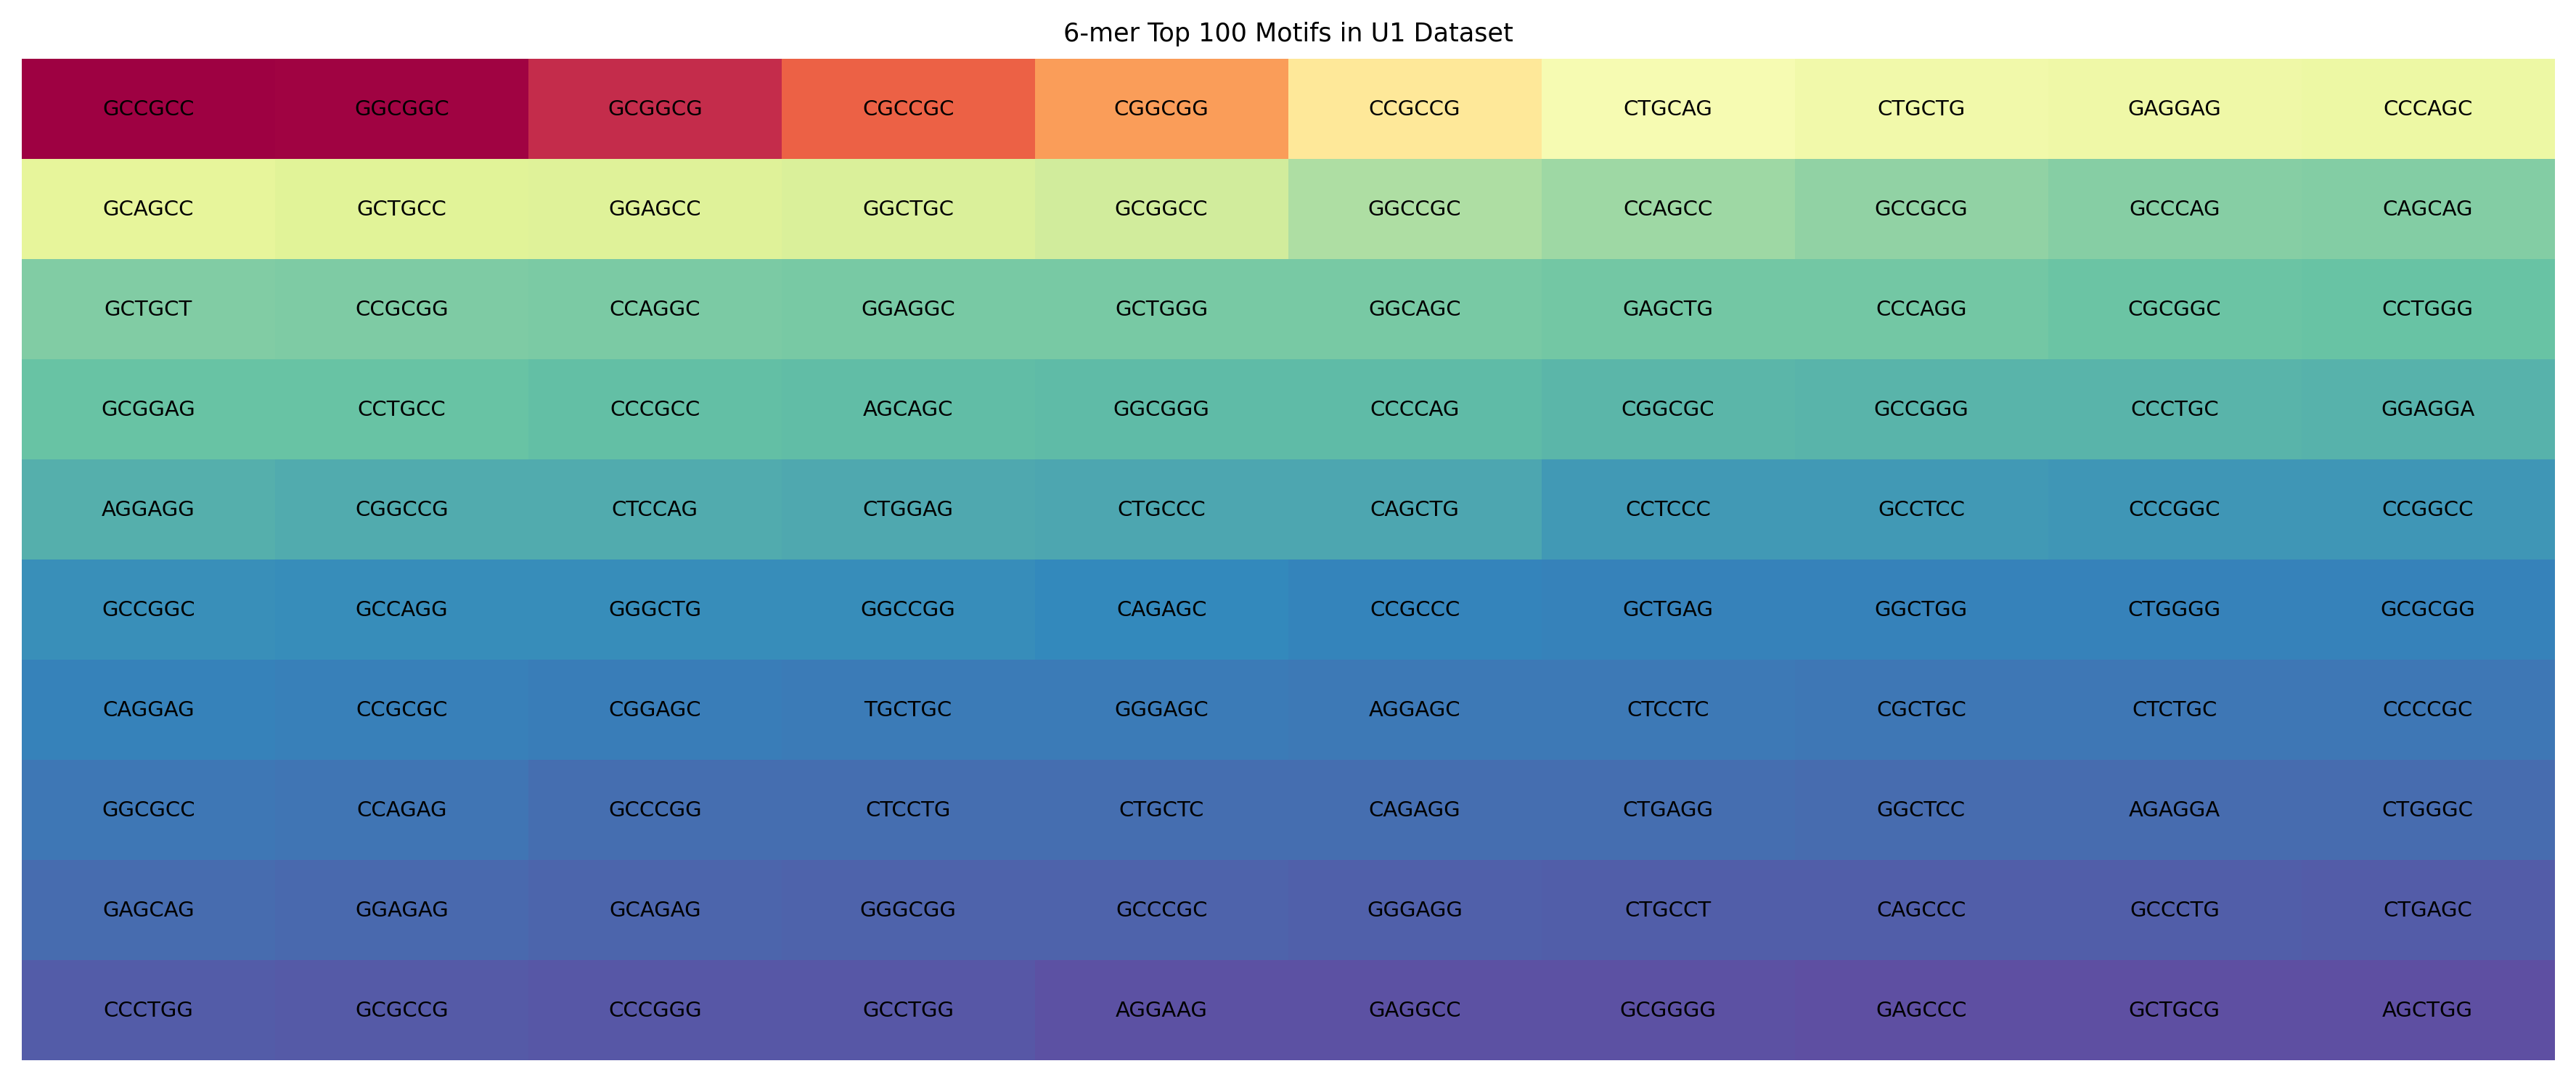

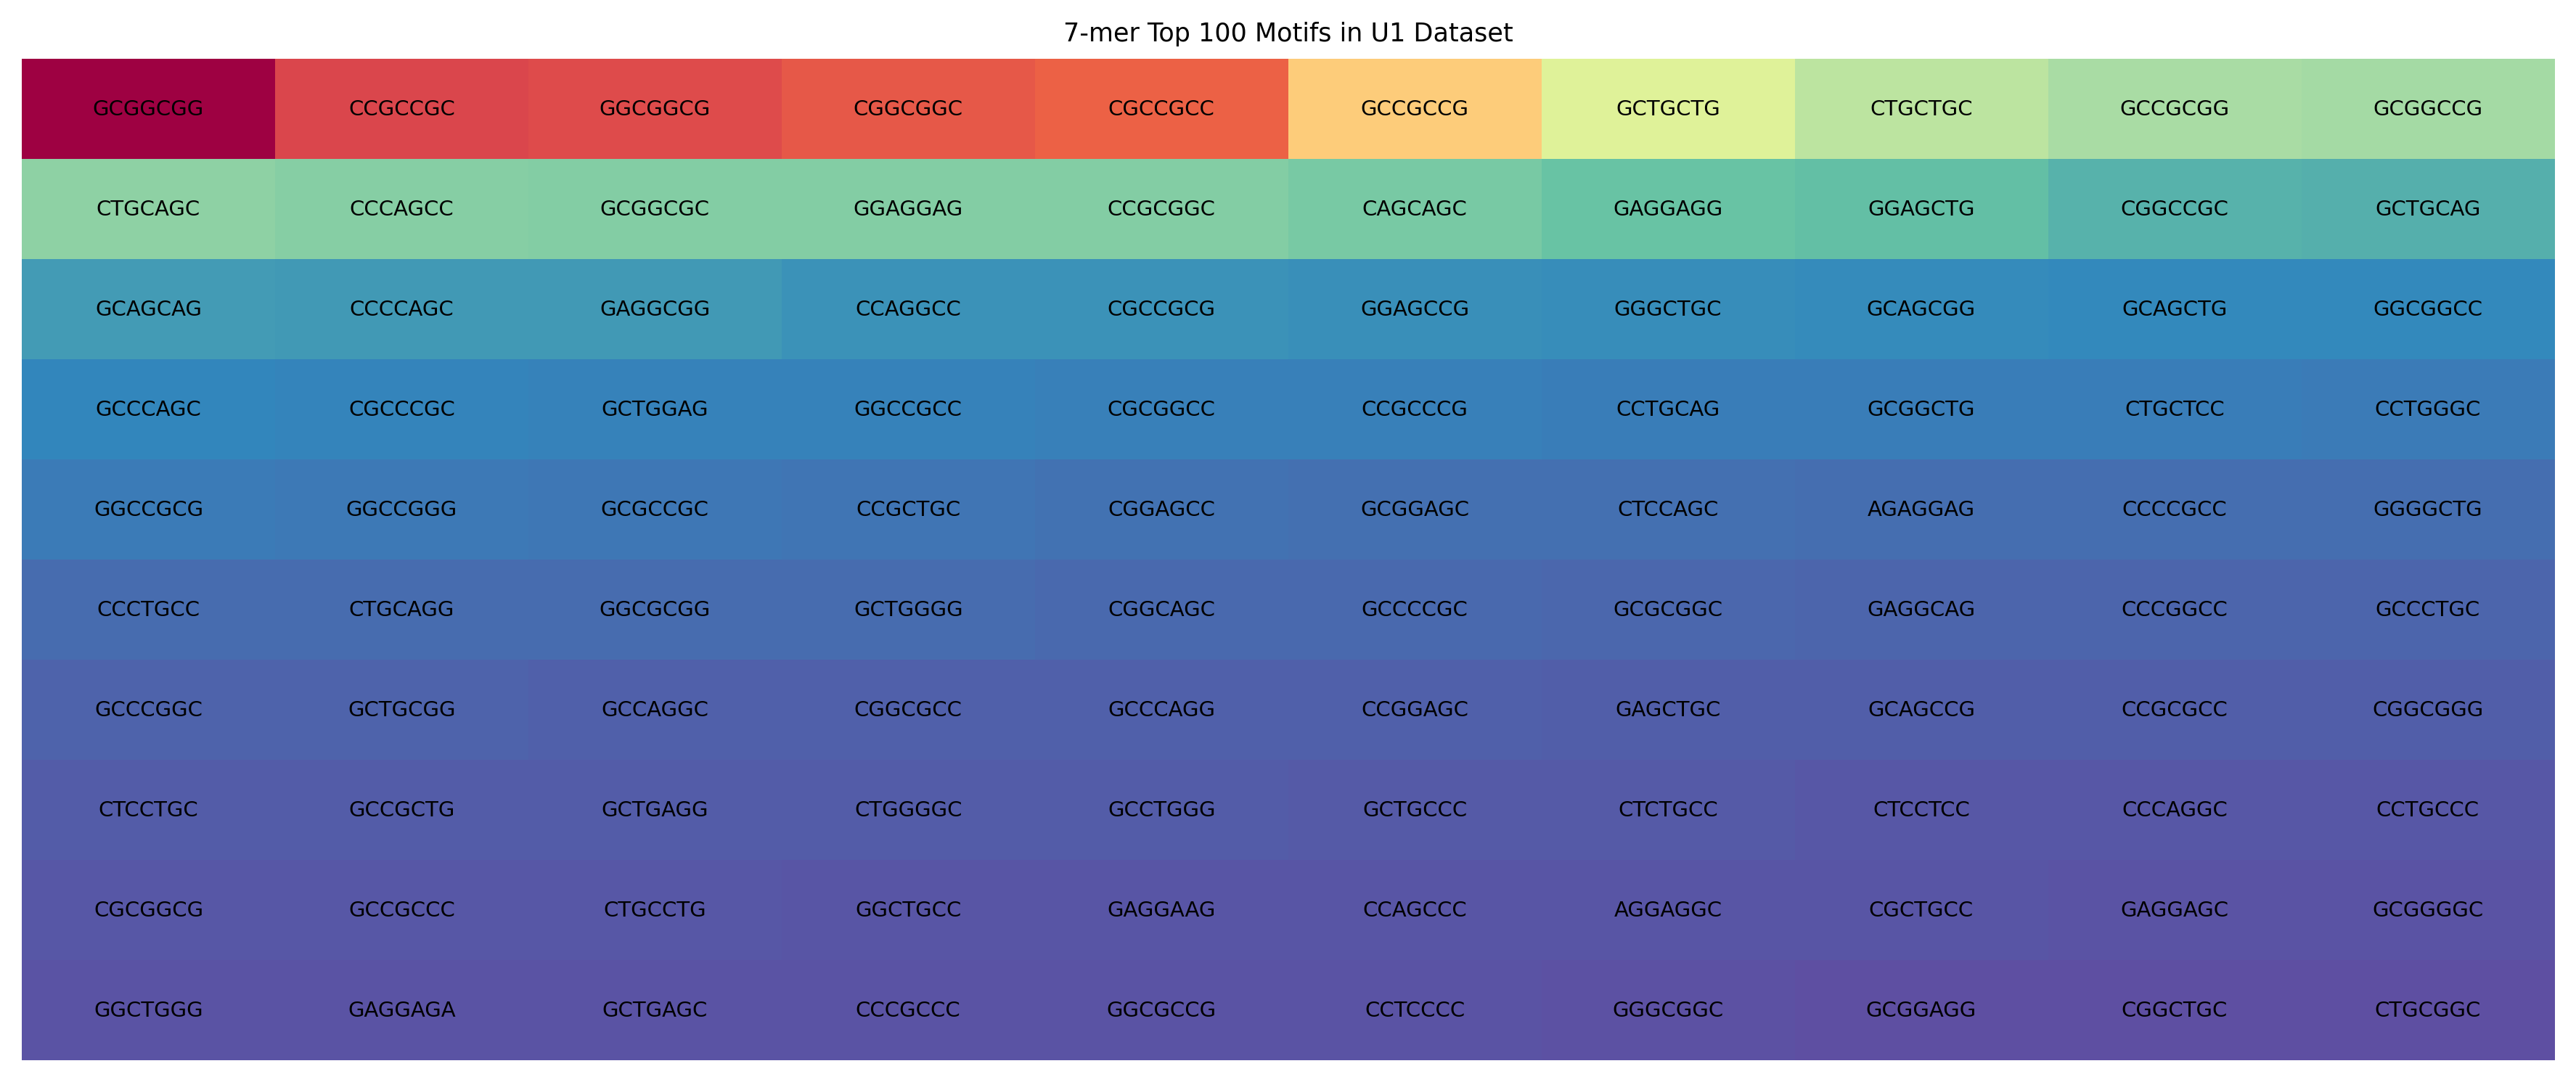

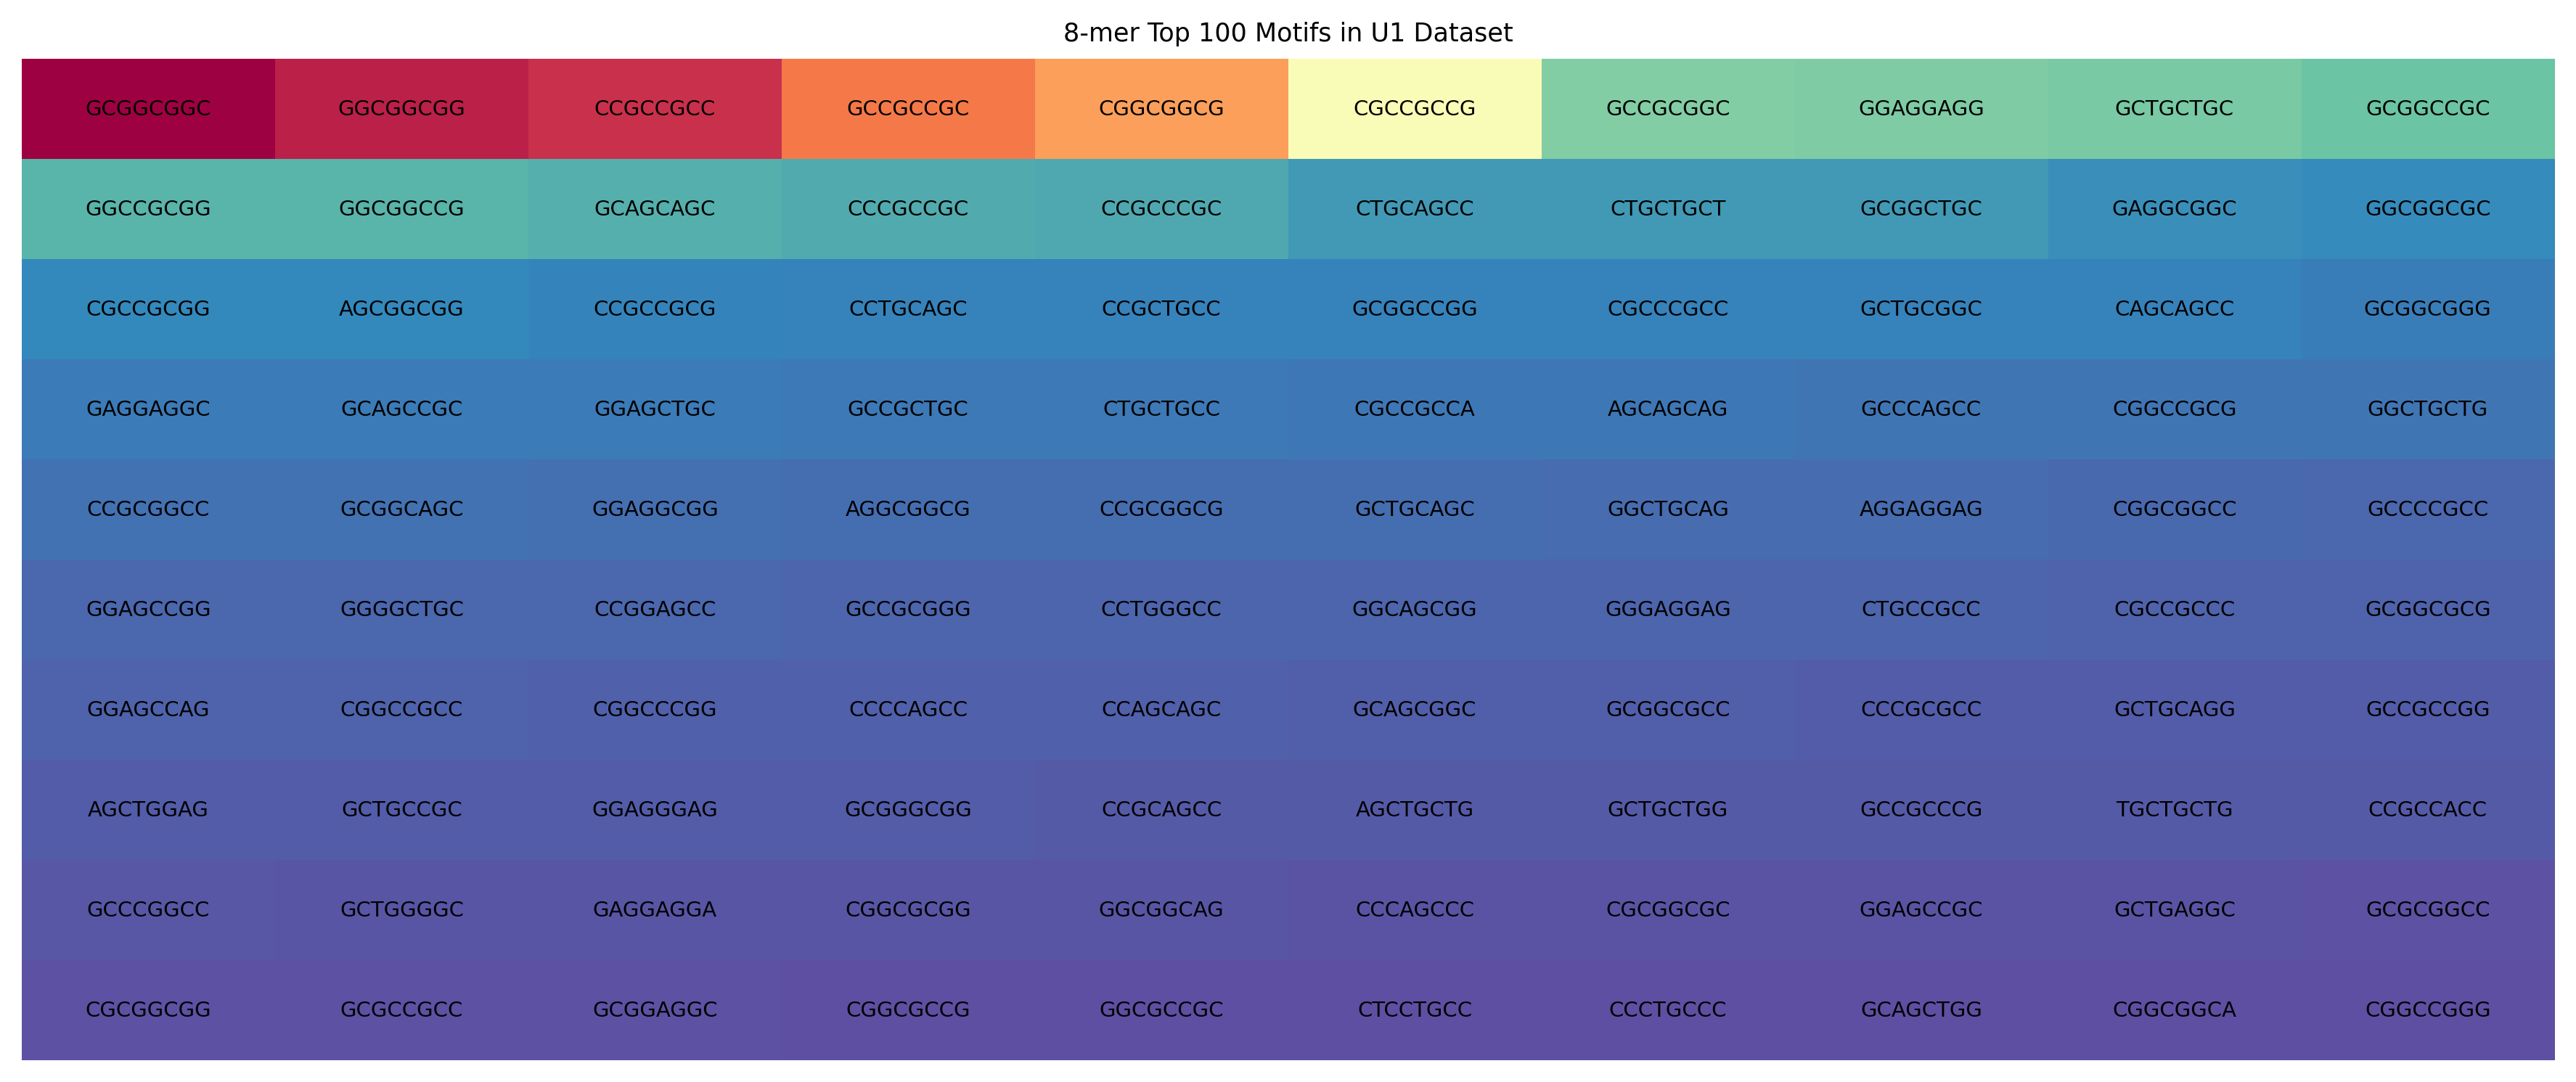

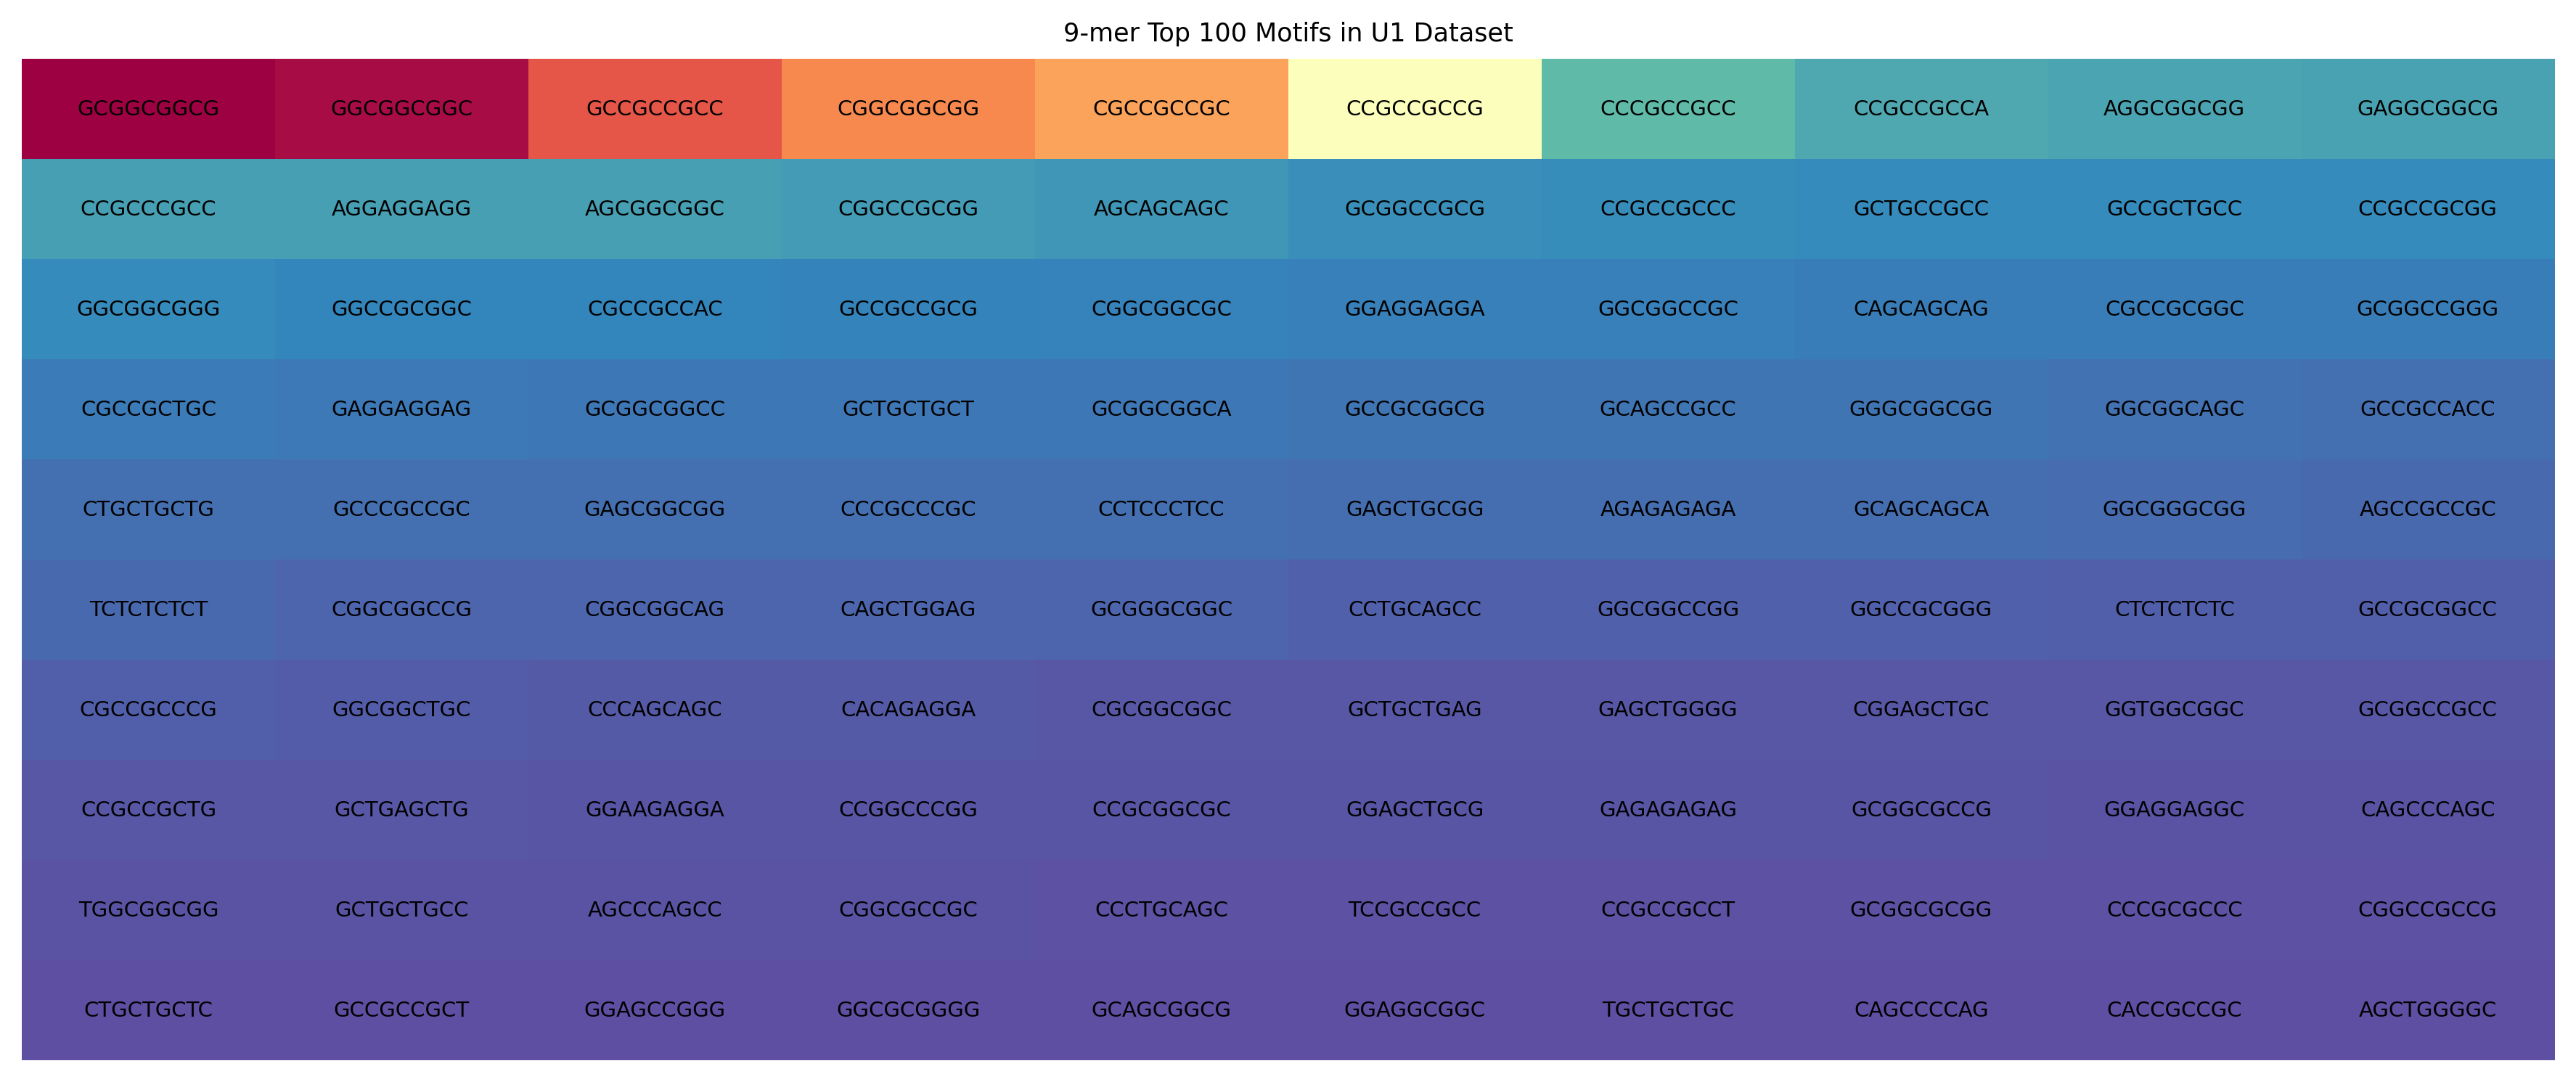

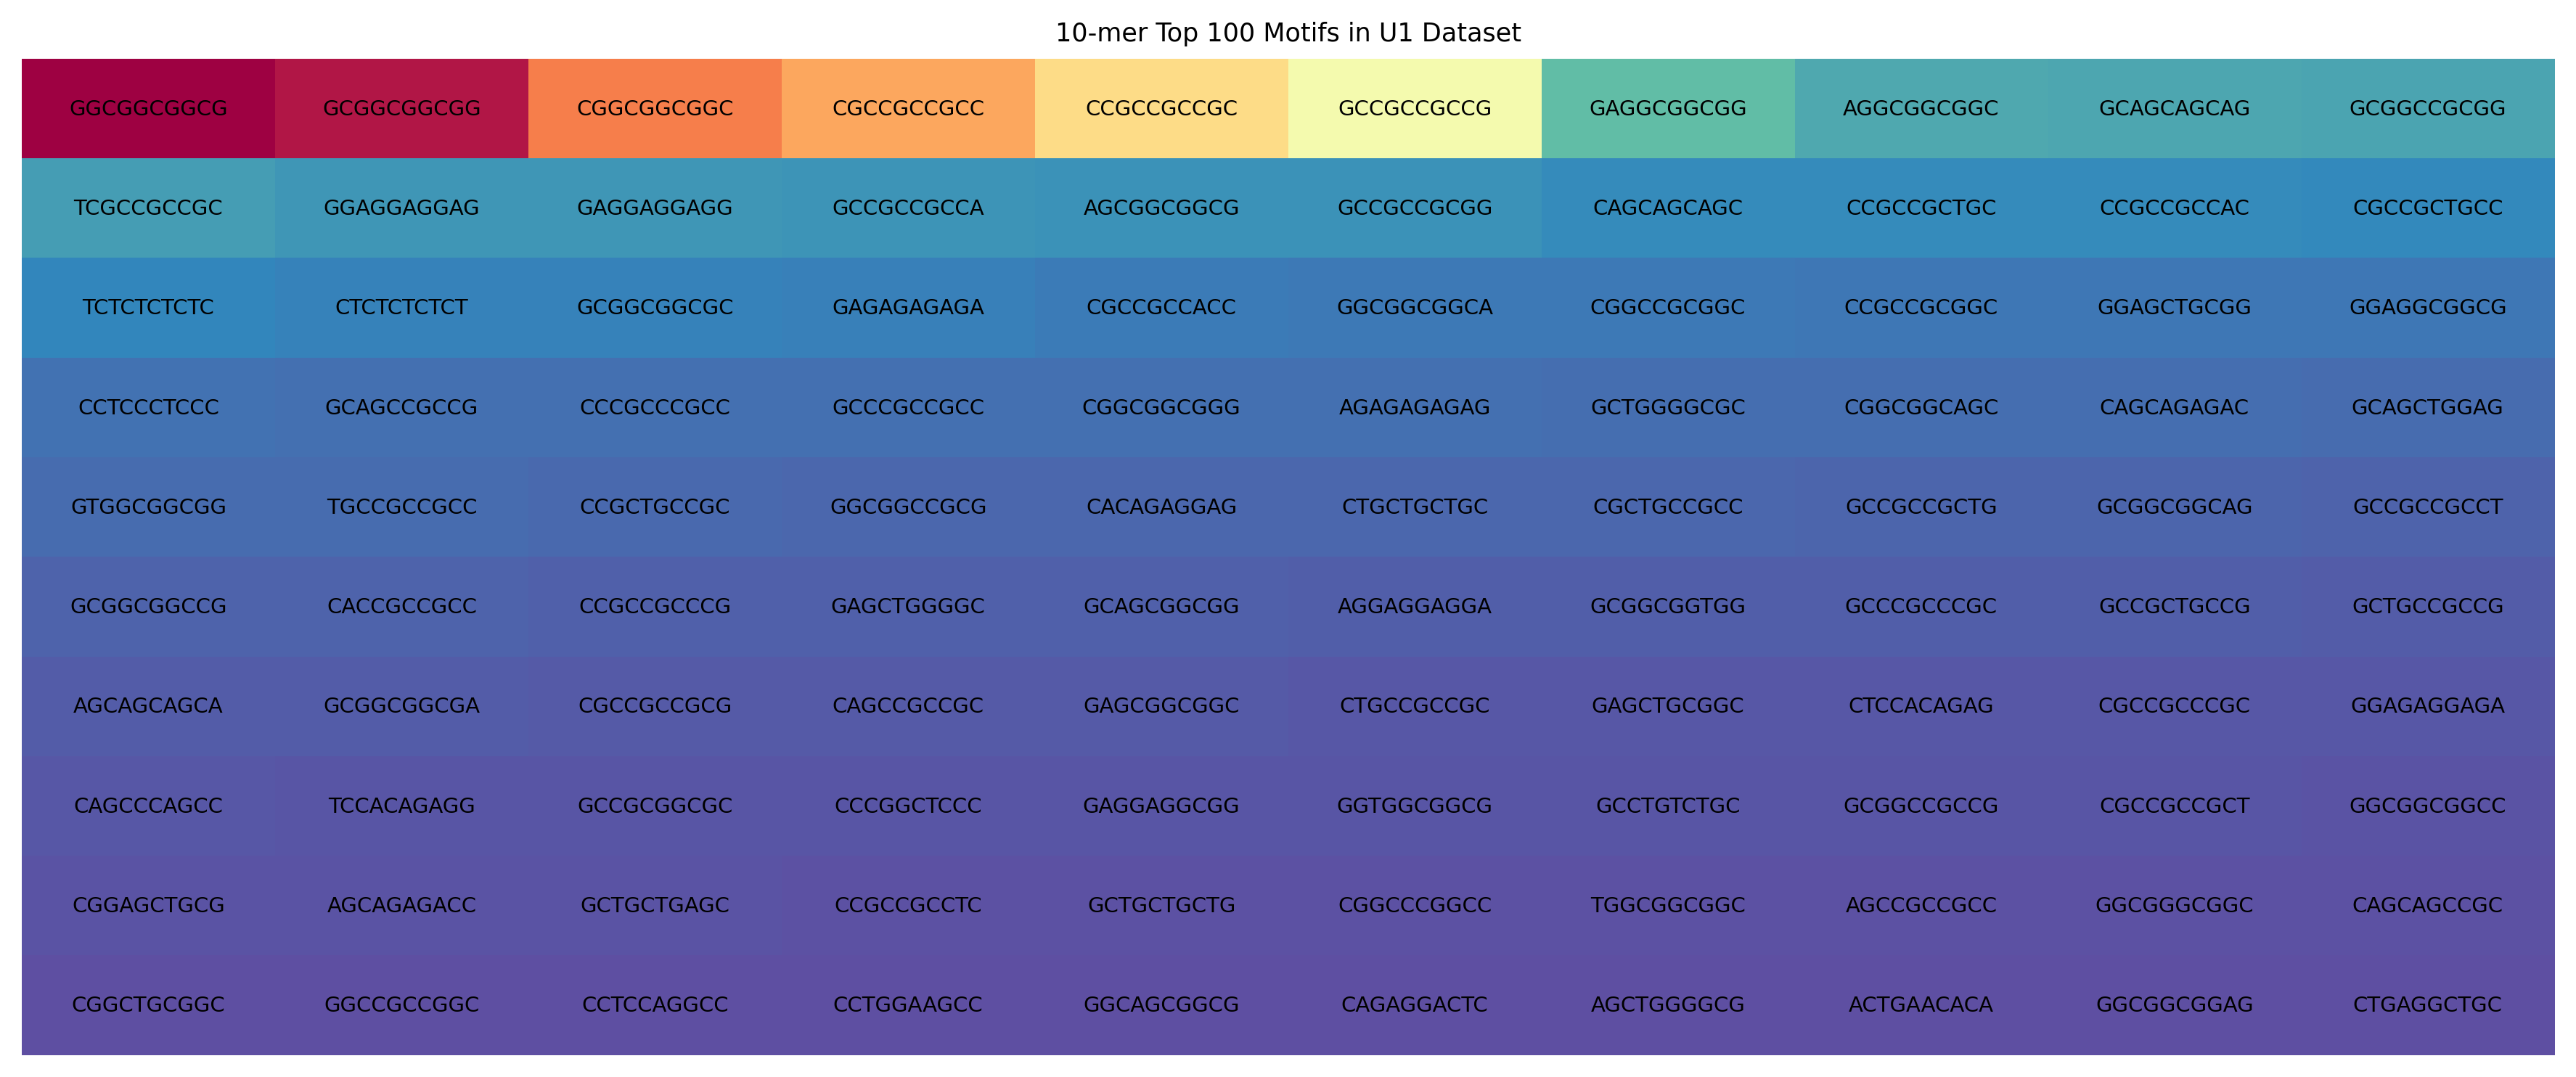

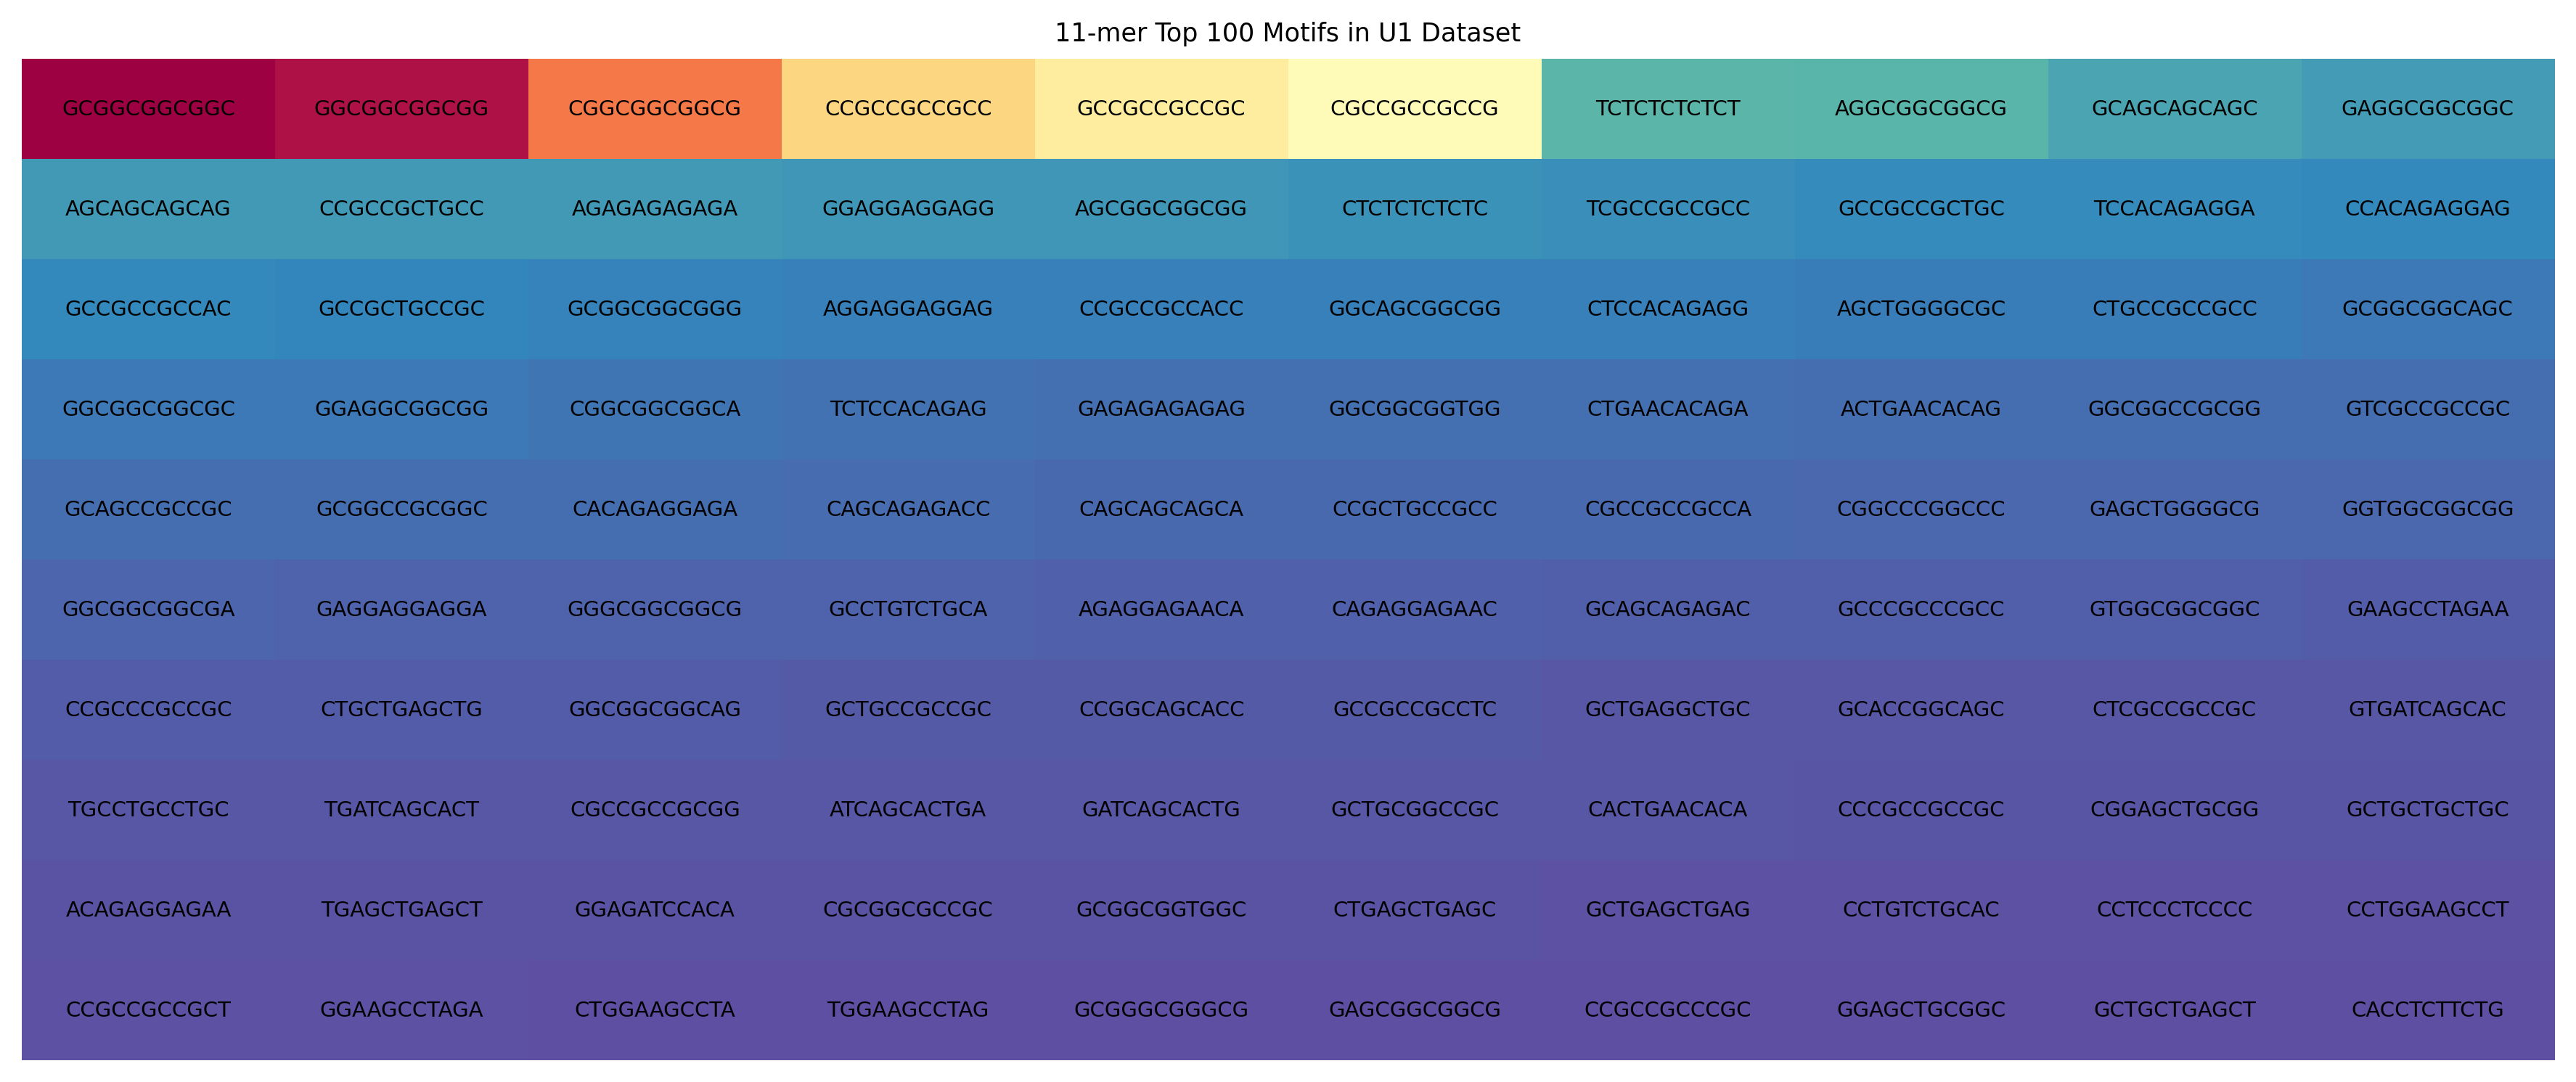

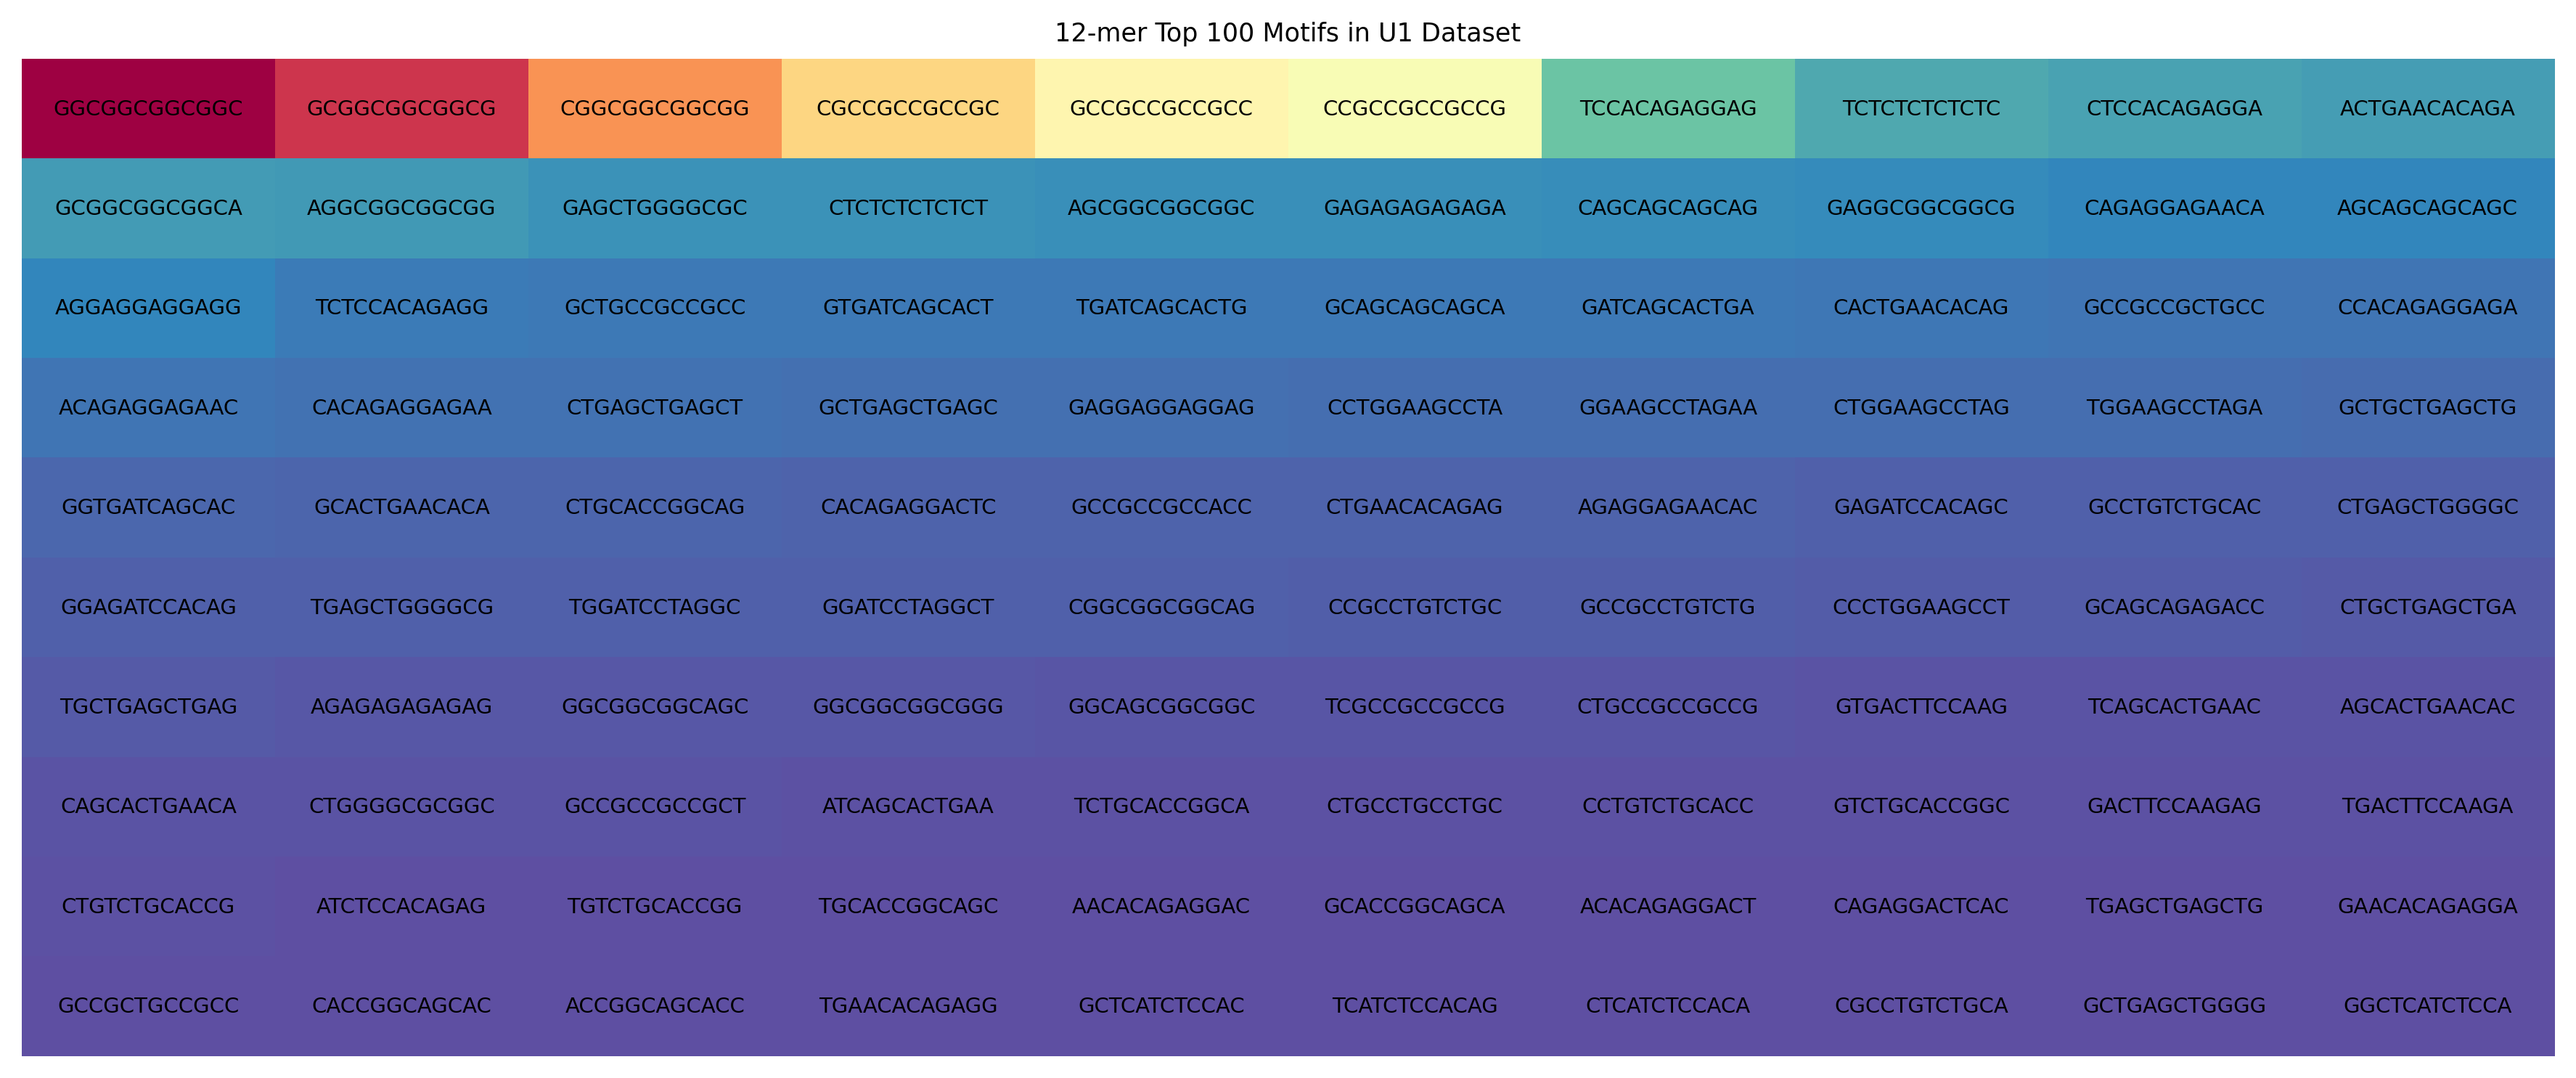

In [64]:
cmap = matplotlib.cm.Spectral_r
for i, heatmap_motif in enumerate(heatmap_motifs):
    fig, ax = plt.subplots(figsize = (top_n*1.2, top_n/2), dpi = 300)
    n = [list(motif_length.keys())[i], '3~12'][list(motif_length.keys())[i] == -1]
    if n == 3: 
        top_n = 9
        heatmap_motif = heatmap_motif[:81]
    else:
        top_n = 10
    heatmap_k, heatmap_v = [item[0] for item in heatmap_motif], [item[1] for item in heatmap_motif]
    im, cbar = heatmap(np.array(heatmap_v).reshape(top_n, top_n), ax = ax, cmap = cmap, cbarlabel = "The number of non-redundant peptide ligands for each HLA allotypes")
    texts = annotate_heatmap(im, reshape_list_tangular(heatmap_k, top_n), np.array(heatmap_v).reshape(top_n, top_n), valfmt="{x}")
    fig.tight_layout()
    plt.title(f'{n}-mer Top {top_n**2} Motifs in U1 Dataset')
    cbar.remove()
    plt.axis('off')
    plt.show()
#     break

In [20]:
rvac_top100 = set(['AGA', 'TTC', 'GAG', 'ATC', 'CGA', 'TAC', 'ACC', 'TCC', 'ATT',
       'CAC', 'TCG', 'ACA', 'CTT', 'AGT', 'GTT', 'GAA', 'CCT', 'TTG',
       'TCT', 'AGC', 'GGA', 'TCA', 'AGG', 'TTT', 'CGC', 'AAA', 'CAG',
       'CGT', 'CAA', 'AAC', 'ACG', 'GAT', 'CTC', 'GCG', 'CCG', 'GCA',
       'CTG', 'CCA', 'ACT', 'GTC', 'TGC', 'GAC', 'ATA', 'GCC', 'TAT',
       'CCC', 'GCT', 'TTA', 'AAT', 'CAT', 'TGT', 'GTA', 'AAG', 'GGG',
       'CTA', 'GTG', 'CGG', 'TGG', 'GGT', 'GGC', 'AGAG', 'TAG', 'GAGA',
       'TAA', 'TTCG', 'AGAA', 'TGA', 'ATTC', 'CGAG', 'AGTT', 'CTTC',
       'GATT', 'TTCC', 'CCTT', 'TTTC', 'TCGA', 'CACC', 'CAGA', 'AGGA',
       'AATC', 'TTGC', 'TACA', 'ACCT', 'GTTT', 'CTGC', 'CGCA', 'ATAC',
       'TCAC', 'GATC', 'TACC', 'TTCA', 'ATCC', 'ACAC', 'TCCT', 'GAGT',
       'CACA', 'AACG', 'TCGC', 'CGTT', 'CCTC'])
varyLength_human_top100 = set([k for (k,v) in motif_attention[:100]])
rvac_varyhuman = rvac_top100.intersection(varyLength_human_top100)
rvac_varyhuman

{'AAA',
 'AAC',
 'AAG',
 'AAT',
 'ACA',
 'ACC',
 'ACG',
 'ACT',
 'AGA',
 'AGAG',
 'AGC',
 'AGG',
 'AGGA',
 'AGT',
 'ATC',
 'ATT',
 'CAA',
 'CAC',
 'CAG',
 'CAGA',
 'CAT',
 'CCA',
 'CCC',
 'CCG',
 'CCT',
 'CCTC',
 'CGA',
 'CGC',
 'CGG',
 'CGT',
 'CTA',
 'CTC',
 'CTG',
 'CTGC',
 'CTT',
 'GAA',
 'GAC',
 'GAG',
 'GAGA',
 'GAT',
 'GCA',
 'GCC',
 'GCG',
 'GCT',
 'GGA',
 'GGC',
 'GGG',
 'GGT',
 'GTC',
 'GTG',
 'GTT',
 'TAA',
 'TAG',
 'TCA',
 'TCC',
 'TCG',
 'TCT',
 'TGA',
 'TGC',
 'TGG',
 'TGT',
 'TTA',
 'TTC',
 'TTG',
 'TTT'}

In [21]:
varyLength_human_top100

{'AAA',
 'AAC',
 'AAG',
 'AAT',
 'ACA',
 'ACC',
 'ACG',
 'ACT',
 'AGA',
 'AGAG',
 'AGC',
 'AGCC',
 'AGG',
 'AGGA',
 'AGGC',
 'AGT',
 'ATC',
 'ATT',
 'CAA',
 'CAC',
 'CAG',
 'CAGA',
 'CAGC',
 'CAGG',
 'CAT',
 'CCA',
 'CCAG',
 'CCC',
 'CCCC',
 'CCCG',
 'CCG',
 'CCGC',
 'CCGG',
 'CCT',
 'CCTC',
 'CCTG',
 'CGA',
 'CGC',
 'CGCC',
 'CGG',
 'CGGC',
 'CGGG',
 'CGT',
 'CTA',
 'CTC',
 'CTCC',
 'CTG',
 'CTGC',
 'CTGG',
 'CTT',
 'GAA',
 'GAAG',
 'GAC',
 'GAG',
 'GAGA',
 'GAGC',
 'GAGG',
 'GAT',
 'GCA',
 'GCAG',
 'GCC',
 'GCCC',
 'GCCG',
 'GCCT',
 'GCG',
 'GCGC',
 'GCGG',
 'GCT',
 'GCTC',
 'GCTG',
 'GGA',
 'GGAG',
 'GGC',
 'GGCC',
 'GGCG',
 'GGCT',
 'GGG',
 'GGGA',
 'GGGC',
 'GGGG',
 'GGT',
 'GTC',
 'GTG',
 'GTT',
 'TAA',
 'TAG',
 'TCA',
 'TCC',
 'TCCC',
 'TCG',
 'TCT',
 'TCTG',
 'TGA',
 'TGC',
 'TGG',
 'TGT',
 'TTA',
 'TTC',
 'TTG',
 'TTT'}

# position

In [65]:
attns.shape

(13216, 50, 50)

In [66]:
seqs

['CTCATTTTCTCTTGCCACCACTAAGTAAGAAGAGCCTTTTGCCTCCCACC',
 'ATGAGAGAGGACTATCATCTGCTCCTTGCTCTGAATTTCTTTGAACCTCC',
 'CTCACCGTGTGATGTCTGGCAGCTGATGCCAGCTATTAGCTGGGACCTCC',
 'AGTTGCTTGGAGAAGCCCGTTCACCGCCTCCAGCTGCTGCTCTCCTCGAC',
 'CTCTCAGCTCTTGCTAAGTGATCACTAGCTTGCCTCCAAGCTCTCTCACT',
 'ATCAGGTCCGAGCTGTGTTGACTACCACTACTTTTCCCTTCGTCTCAATT',
 'ACACTTTCTTCTGACATAACAGTGTTCACTAGCAACCTCAAACAGACACC',
 'GCGTGGTACGTGACTGGAGGTGTATCCTTGTCCTCGTCTGAATCACGCTG',
 'ATTTTCTCTTTGGATTCTTCCAAAATCAGAGTCAGACTACTCCCTGTGCC',
 'TCACTTCTTCAACTGAGATGGACATGATATAATCTCCATTGAGTCAAAGA',
 'CCTCAGAAGCATCTTCTTGAAACCCATCTCAATTCTCTCCTCTTGACAAC',
 'GAAGTGGTAGCAGTTCCTCCTAACTCCTGCCAGAAACAGCTCTCCTCAAC',
 'GAGTTGCCGCCGGAGAGGAGTGGCCTCGCCCGCTTGAGTTTTGATTCATC',
 'TGTTACAGGTATCCATTTTTCAGCTATATTAATCTTTTAAAACAAAGAAA',
 'TCAAGGCCCCAGGACATGCAGAACCTTCCTCTAGAACCCGACCCACCACC',
 'GAGCAGCCGGTCCTCCAGTGGCTCCGCTCCCCGTTCTCTGTGGGCTCAAA',
 'ACATTTGCTTCTGACACAACTGTGTTCACTAGCAACCTCAAACAGACACC',
 'ACAACCACATCCCTCCTCTAGAGAATCCCCTGAAAGCACAGCTCCTCACC',
 'TAAGAACC

# NucType-Position

In [67]:
def attn_HLA_length_aatype_position_num(data, attn_data, hla = 'HLA-A*11:01', label = None, length = 9, show_num = False):
    aatype_position = dict()
    if label == None:
        length_index = np.array(data[data.length == length][data.HLA == hla].index)
    else:
        length_index = np.array(data[data.length == length][data.HLA == hla][data.label == label].index)

    length_data_num = len(length_index)

    for head in range(9):
        for idx in length_index:
            temp_peptide = data.iloc[idx].peptide
            temp_length_head = deepcopy(nn.Softmax(dim=-1)(attn_data[idx][head][:, :length].float())) # Shape = (34, 9), 行是HLA，列是peptide，由行查列
            temp_length_head = nn.Softmax(dim=-1)(temp_length_head.sum(axis = 0)) # 把这一列的数据相加，shape = （9，）

            for i, aa in enumerate(temp_peptide): 
                aatype_position.setdefault(aa, {})
                aatype_position[aa].setdefault(i, 0)
                aatype_position[aa][i] += temp_length_head[i] 
    
    if show_num:
        aatype_position_num = dict()
        for idx in length_index:
            temp_peptide = data.iloc[idx].peptide
            for i, aa in enumerate(temp_peptide):
                aatype_position_num.setdefault(aa, {})
                aatype_position_num[aa].setdefault(i, 0)
                aatype_position_num[aa][i] += 1
             
        return aatype_position, aatype_position_num
    else:
        return aatype_position


In [68]:
nuctype_position = dict()
attn_nuctype_position = deepcopy(torch.Tensor(attns))
attn_nuctype_position = nn.Softmax(dim = -1)(attn_nuctype_position) # 对每个instance取由行查列的attn归一化
attn_nuctype_position = attn_nuctype_position.sum(dim = 1) # 对每个instance的列相加
print(attn_nuctype_position.shape)
for s_i, seq in tqdm(enumerate(seqs)):
    for n_i, nuc in enumerate(seq):
        nuctype_position.setdefault(nuc, {})
        nuctype_position[nuc].setdefault(n_i, 0)
        nuctype_position[nuc][n_i] += attn_nuctype_position[s_i][n_i]


torch.Size([13216, 50])


13216it [00:03, 3698.57it/s]


In [69]:
nuctype_position_pd = np.zeros((5, 50))

nuc_i, nuc_indexs = 0, []
for nuc, nuc_posi in tqdm(nuctype_position.items()):
    nuc_indexs.append(nuc)
    for posi, v in nuc_posi.items():
        nuctype_position_pd[nuc_i, posi] = v
    nuc_i += 1

nuctype_position_pd_unsoftmax = pd.DataFrame(nuctype_position_pd, index = nuc_indexs, columns = range(50,0, -1))

nuctype_position_pd_softmax = deepcopy(nn.Softmax(dim = -1)(torch.Tensor(nuctype_position_pd)))
nuctype_position_pd_softmax = pd.DataFrame(nuctype_position_pd_softmax, index = nuc_indexs, columns = range(50,0, -1))

100%|██████████| 5/5 [00:00<00:00, 7738.57it/s]


In [70]:
nuctype_position_pd_unsoftmax

50           49           48           47           46           45           44           43           42           41           40           39           38           37           36           35           34           33           32           31           30           29           28           27           26           25           24           23           22           21           20           19           18           17           16           15           14           13           12           11           10           9            8            7            6            5            4            3            2            1 
C  2372.843994  3200.922363  2869.883057  3046.566162  3017.378418  2714.757812  2691.882568  2887.478027  2908.330078  2884.038330  3206.418457  3190.276855  3285.594727  3357.750977  3445.374756  3535.897949  3664.304688  3608.432617  3704.386230  3903.720703  3958.979248  4034.139648  4189.215820  4232.687988  4324.698730  4519.514160  4350.305176  4231.761230  4467.332520  4223.060547  4288.416016  4292.433105  4323.463867  4665.324219  4799.614746  4367.255859  4411.339844  4478.492188  4488.493652  4807.243164  4631.588867  3806.509766  4887.059570  5139.934082  3557.109375  5051.568848  7278.120117  1687.877563  7190.474121  5577.196289
T  1727.519531  1900.607910  1852.805176  1947.609009  1840.133911  1734.187134  1826.479004  1872.260254  1989.685181  1980.383301  2000.839600  2179.875732  2212.139404  2236.163818  2293.461914  2310.928955  2453.251709  2534.480469  2501.893555  2506.255859  2675.911865  2662.617188  2767.953857  2738.380371  2519.837158  2545.956299  2766.155518  2743.810303  2726.177734  2782.386719  2664.541504  2597.249023  2709.356201  2487.448486  2707.268799  2722.292480  2568.640137  2481.743896  2482.111572  2428.651855  2662.198242  2482.100098  2450.985840  2639.500732  2376.129639  2552.163818  2049.652344  1143.635864  2525.308838  1024.020264
A  1566.818970  1880.156494  1823.734253  2013.981445  1921.744629  1698.470703  1725.724487  1762.359497  1831.441406  1890.617676  1949.802734  1969.446777  2017.269043  2144.096436  2122.471680  2141.841064  2129.081299  2298.476318  2266.130127  2368.227295  2504.798096  2527.361816  2505.369873  2588.088867  2610.007568  2678.679199  2706.983398  2665.657959  2557.245361  2556.404541  2682.353516  2644.408691  2568.911377  2669.477051  2680.115967  2569.547852  2738.219238  2711.503418  2517.155273  2769.190674  2992.686035  2627.536377  2746.817627  2812.112305  2792.074219  2518.718262  3889.602295  7615.012695  6055.931152  2922.804932
G  2631.886475  3681.292725  2760.043701  2966.138916  2822.317139  2603.860107  2466.967285  2618.877930  2638.240479  2833.817871  2727.091553  2789.768799  2884.396973  2945.592529  3054.331299  3125.607422  3137.933105  3287.782227  3366.728271  3414.580078  3398.775391  3501.908936  3593.567627  3820.160400  4019.989014  3853.217285  3935.512207  3966.042480  3780.981689  3919.822998  3874.920166  3650.196533  3979.257080  3769.816406  3414.031250  3885.655518  3810.447754  3536.412842  3895.869629  3593.929932  3397.705566  4549.755371  3615.111816  3357.260010  5053.617188  3778.190186  3806.021240  5693.700195  2651.167725  3201.847656
N  2840.351807  2774.021729  2699.082764  2626.591064  2552.859863  2471.921387  2389.920410  2311.121826  2212.435059  2117.471680  2011.827759  1917.968384  1806.739624  1703.322510  1578.600220  1464.009888  1344.225220  1222.922607  1083.937012   924.491150   775.939880   646.367737   484.904327   321.317261   166.264328     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000

In [71]:
nuctype_position_pd_softmax

50            49   48   47   46   45   44   43   42   41   40   39   38   37   36   35   34   33   32   31   30   29            28            27   26   25            24            23            22        21   20   19            18   17            16            15   14   13   12   11   10   9    8    7    6    5    4    3             2    1 
C  0.0  0.000000e+00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00  0.0  0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  0.0  0.0  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  8.626360e-39  0.0
T  0.0  0.000000e+00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.393711e-07  7.731892e-20  0.0  0.0  8.930559e-08  1.763905e-17  3.879252e-25  0.999999  0.0  0.0  1.919769e-32  0.0  2.380683e-33  7.968997e-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.0
A  0.0  0.000000e+00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00  0.0  0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  0.0  0.0  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.000000e+00  0.0
G  0.0  0.000000e+00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00  0.0  0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  0.0  0.0  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.000000e+00  0.0
N  1.0  1.560318e-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00  0.0  0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  0.0  0.0  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.0

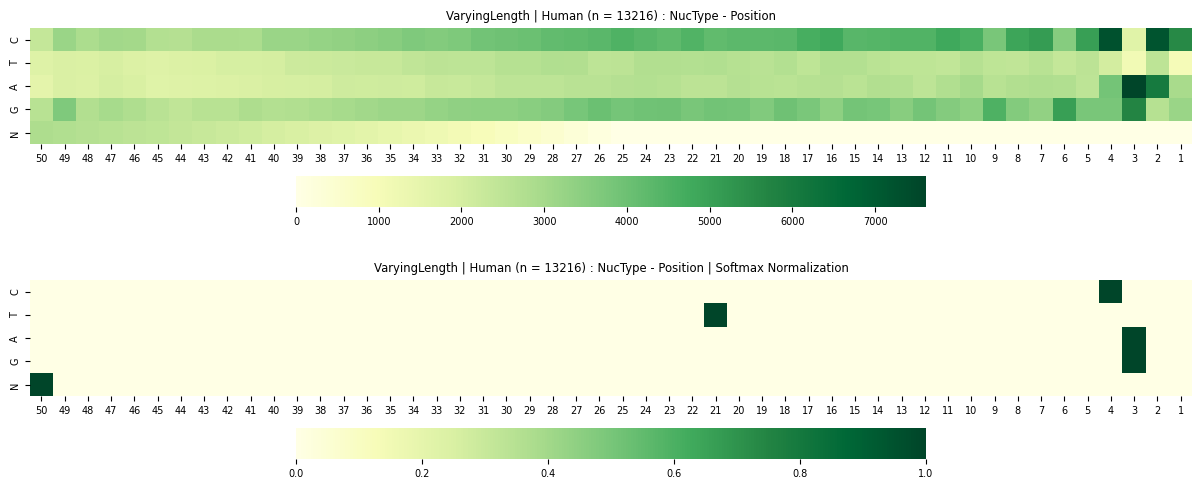

In [72]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 6))
cmap = 'YlGn'
sns.heatmap(nuctype_position_pd_unsoftmax,
            ax = axes[0], cmap = cmap, square = True, cbar = False)
norm_unsoftmax = mpl.colors.Normalize(vmin = nuctype_position_pd_unsoftmax.values.min(),
                                    vmax = nuctype_position_pd_unsoftmax.values.max())
cbar_unsoftmax = fig.colorbar(mpl.cm.ScalarMappable(norm = norm_unsoftmax, cmap = cmap),
                            orientation = 'horizontal', ax = axes[0])
cbar_unsoftmax.outline.set_visible(False)
axes[0].set_title(f'VaryingLength | Human (n = {len(attns)}) : NucType - Position')


sns.heatmap(nuctype_position_pd_softmax,
            ax = axes[1], cmap = cmap, square = True, cbar = False)

norm_softmax = mpl.colors.Normalize(vmin = nuctype_position_pd_softmax.values.min(),
                                    vmax = nuctype_position_pd_softmax.values.max())
cbar_softmax = fig.colorbar(mpl.cm.ScalarMappable(norm = norm_softmax, cmap = cmap),
                            orientation = 'horizontal', ax = axes[1])
cbar_softmax.outline.set_visible(False)
axes[1].set_title(f'VaryingLength | Human (n = {len(attns)}) : NucType - Position | Softmax Normalization')
plt.show()

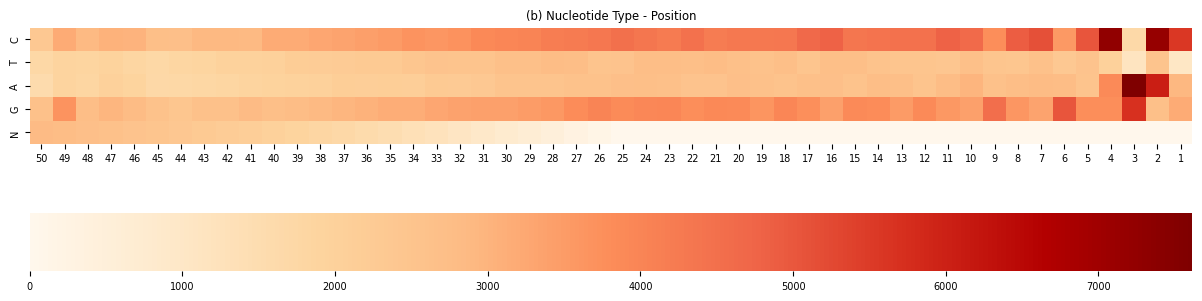

In [73]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 6))
cmap = 'OrRd'
sns.heatmap(nuctype_position_pd_unsoftmax,
            ax = axes, cmap = cmap, square = True, cbar = False)
norm_unsoftmax = mpl.colors.Normalize(vmin = nuctype_position_pd_unsoftmax.values.min(),
                                    vmax = nuctype_position_pd_unsoftmax.values.max())
cbar_unsoftmax = fig.colorbar(mpl.cm.ScalarMappable(norm = norm_unsoftmax, cmap = cmap),
                            orientation = 'horizontal', ax = axes)
cbar_unsoftmax.outline.set_visible(False)
axes.set_title(f'(b) Nucleotide Type - Position')

plt.savefig('VaryingLength_Human_13216_nuctype_position.svg')
plt.show()

# positional

In [74]:
# positional
attn_position = deepcopy(torch.Tensor(attns))
attn_position = nn.Softmax(dim = -1)(attn_position) # 对每个instance取由行查列的attn归一化
attn_position = attn_position.sum(dim = 0) # 对所有instance的attn相加
attn_position = np.array((attn_position.sum(axis = 0)))# 把这一列的数据相加
print(attn_position.shape)

(50,)


/tmp/ipykernel_1354235/954436106.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap),


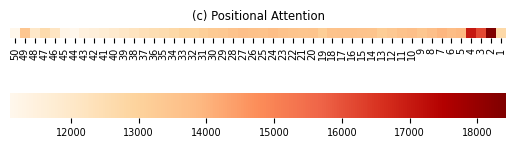

In [75]:
# draw_eachlength_head_pepposition(sum_peplength_pepposition, label, savepath = False)
fig = plt.figure()

cmap = 'OrRd'
sns.heatmap(attn_position.reshape(-1, 1).T, cmap = cmap, cbar = False, square = True,
            xticklabels = range(50,0,-1), yticklabels = '')

plt.title(f'(c) Positional Attention')
# plt.xlabel("5'UTR position")
plt.ylabel('')

norm = mpl.colors.Normalize(vmin = min(attn_position), vmax = max(attn_position))
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), 
                    orientation='horizontal') # , anchor = (-0.2, 0.5), shrink = 0.5
cbar.outline.set_visible(False)

plt.savefig('VaryingLength_Human_13216_position.svg')
plt.show()

# onesample

/tmp/ipykernel_1354235/1734731228.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap),


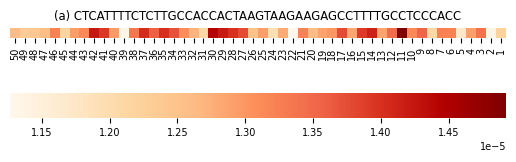

In [76]:
# draw_eachlength_head_pepposition(sum_peplength_pepposition, label, savepath = False)
fig = plt.figure()

cmap = 'OrRd'
single_data_attn = attns[0].sum(axis = 1).reshape(50,1).T
sns.heatmap(single_data_attn, cmap = cmap, cbar = False, square = True,
            xticklabels = range(50,0,-1), yticklabels = '')

plt.title(f'(a) {seqs[0]}')
# plt.xlabel("Neuclotide position")
plt.ylabel('')

norm = mpl.colors.Normalize(vmin = min(single_data_attn[0]), vmax = max(single_data_attn[0]))
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), 
                    orientation='horizontal') # , anchor = (-0.2, 0.5)
cbar.outline.set_visible(False)

plt.savefig('single_data_attn.svg')
plt.show()